In [1]:
!pip install pvlib pandas numpy tabulate

=== Iniciando simulação multi-Inversor/MPPT ===
Buscando PVGIS: -23.7617,-53.3292 [2015-2020]
✅ PVGIS OK: 52608 registros. GHI média: 208.4 W/m²
PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=45, surface_azimuth=45, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {'a': -2.98, 'b': -0.0471, 'deltaT': 1}
    strings: 2
    modules_per_string: 12
  inverter: None
Index(['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed', 'poa_global',
       'poa_direct', 'poa_diffuse'],
      dtype='object')
MPPT MPPT-1A: kWp=13.20, DC Energia Anual (kWh): 144702.5, Pico DC (W): 13973.6

=== RESULTADO FINAL DO SISTEMA ===
Sistema total: 13.20 kWp | 1 Inversores
----------------------------------------
☀️ Geração DC Total (Teórica, sem perdas): 20,672 kWh/ano
✂️ Perda por Clipping: 7,971 kWh/ano (39.35 %)
⚡ Geração AC Total (Pré-Perdas Elétricas/Soiling): 12,287 kWh/ano

⚡ Geração AC Final (Pós-

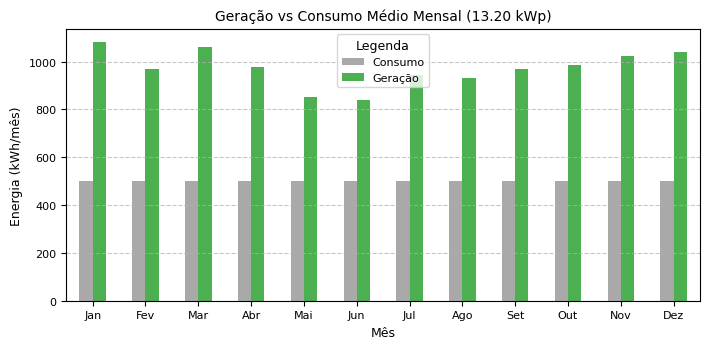

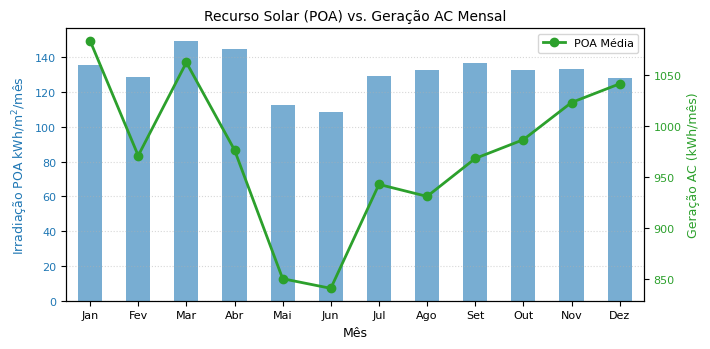

In [ ]:
import math
import requests
import pandas as pd
import numpy as np
import pvlib
from pvlib import location, solarposition, irradiance, pvsystem, modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
# from pvlib.iotools import get_nasa_power
import matplotlib.pyplot as plt
from tabulate import tabulate

# ---------------------------
# CONFIGURAÇÃO INICIAL (INALTERADA)
# ---------------------------

# === ENTRADA DE DADOS DO USUÁRIO ===
# Informe o consumo médio mensal de JANEIRO a DEZEMBRO (em kWh)
monthly_consumption_kwh = [
    500, 500, 500, 500, 500, 500, # Jan a Jun
    500, 500, 500, 500, 500, 500  # Jul a Dez
]
# Define a fonte de dados preferencial: 'NASA' ou 'PVGIS'
# Se a fonte preferencial falhar, ele tenta a outra. Se as duas falharem, usa o sintético.
PREFERRED_DATA_SOURCE = 'PVGIS' # <=== Mude para 'PVGIS' se for a preferência
# =========================================

# NOVO: CONFIGURAÇÃO DE MÚLTIPLOS INVERSORES E SEUS MPPTs
inverter_configs = [
    {
        'name': 'INV-01 (3.0kW)',
        'paco_w': 5000, # Potência nominal AC do primeiro inversor (W)
        'efficiency_dc_ac': 0.98, # NOVO: Eficiência Nominal (98%)
        'mppts': [
            {'tilt': 45, 'azimuth': 45, 'modules_per_string': 12, 'strings': 2, 'id': 'MPPT-1A'},
        ]
    }
]

# Coordenadas
lat, lon = -23.7617, -53.3292

potencia_modulo = 550 # Wp

# Perdas Totais
losses_parameters = {'soiling': 1.0, 'shading': 2.0, 'mismatch': 1.0, 'wiring': 0.5, 'Other': 0.5}

module_parameters = {
    'alpha_sc': 0.00041, 'beta_oc': -0.0025, 'gamma_r': -0.0029, 'cells_in_series': 144,
    'STC': potencia_modulo, 'V_oc_ref': 51.16, 'I_sc_ref': 14.55, 'V_mp_ref': 42.52,
    'I_mp_ref': 13.76, 'a_ref': 1.8, 'I_L_ref': 14.86, 'I_o_ref': 2.5e-12,
    'R_s': 0.25, 'R_sh_ref': 450.0,
}

# Opções: 'open_rack_glass_glass' (solo/aberto) ou 'close_mount_glass_glass' (telhado/restrito)
mount_type = 'close_mount_glass_glass'

# ---------------------------
# Funções utilitárias (FUNÇÃO NASA CORRIGIDA)
# ---------------------------

def buscar_dados_nasa(lat, lon, startyear=2015, endyear=2020, timeout=60):
    """
    Busca dados climáticos horários da API NASA POWER usando get_nasa_power.
    """
    try:
        print(f"Buscando NASA POWER: {lat},{lon} [Anos: {startyear}-{endyear}]")

        # A API retorna dados horários por padrão
        df_utc, metadata = get_nasa_power(
            latitude=lat,
            longitude=lon,
            start=f'{startyear}-01-01',
            end=f'{endyear}-12-31',
            parameters=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'],
            community='re',
            map_variables=True
        )
    except Exception as e:
        print("❌ Erro NASA POWER:", e)
        return None

    if df_utc.empty:
        print("❌ NASA POWER retornou dados vazios.")
        return None

    df = df_utc.copy()

    # 1. Tratar NaNs e garantir float
    for col in ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
        else:
            print(f"⚠️ Aviso: Coluna '{col}' não encontrada nos dados da NASA.")

    # 2. Definir fuso horário (NASA já retorna com tz-aware (UTC), então usamos apenas tz_convert)
    try:
        df.index = df.index.tz_convert('America/Sao_Paulo') # <--- CORREÇÃO APLICADA AQUI
    except TypeError as e:
        # Se por acaso a conversão falhar (dados não-aware), forçamos o localize e tentamos converter
        if "Already tz-aware" not in str(e):
             print("⚠️ Tentando forçar o fuso horário (timezone localization fallback).")
             df.index = df.index.tz_localize('UTC').tz_convert('America/Sao_Paulo')
        else:
             print(f"❌ Erro de fuso horário irrecuperável: {e}")
             return None

    # 3. Filtra apenas o ano necessário para a simulação
    df = df[(df.index.year >= startyear) & (df.index.year <= endyear)]
    df = df[~df.index.duplicated(keep='first')]

    print(f"✅ NASA POWER OK: {len(df)} registros. GHI média: {df['ghi'].mean():.1f} W/m²")
    return df

def buscar_dados_pvgis(lat, lon, startyear=2015, endyear=2020, timeout=60):
    url = f"https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={lat}&lon={lon}&startyear={startyear}&endyear={endyear}&outputformat=json&usehorizon=1&selectrad=1&angle=0&aspect=0"
    try:
        print(f"Buscando PVGIS: {lat},{lon} [{startyear}-{endyear}]")
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        data = r.json()
    except Exception as e:
        print("❌ Erro PVGIS:", e)
        return None
    recs = []
    hourly = data.get('outputs', {}).get('hourly', [])
    for rec in hourly:
        try:
            dt = pd.to_datetime(rec['time'], format='%Y%m%d:%H%M', utc=True)
            recs.append({
                'datetime': dt,
                'ghi': float(rec.get('G(i)', 0.0)),
                'dni': float(rec.get('Gb(n)', 0.0)),
                'dhi': float(rec.get('Gd(i)', 0.0)),
                'temp_air': float(rec.get('T2m', 25.0)),
                'wind_speed': float(rec.get('WS10m', 2.0))
            })
        except:
            continue
    df = pd.DataFrame(recs).set_index('datetime')
    if df.empty:
        return None
    df.index = df.index.tz_convert('America/Sao_Paulo')
    print(f"✅ PVGIS OK: {len(df)} registros. GHI média: {df['ghi'].mean():.1f} W/m²")
    return df

def gerar_dados_sinteticos(lat, lon, start='2019-01-01', end='2019-12-31', tz='America/Sao_Paulo'):
    print("Gerando dados sintéticos (clear-sky) com perfil climático aprimorado...")
    times = pd.date_range(start=start, end=end, freq='1h', tz=tz)
    site = location.Location(lat, lon, tz=tz)
    cs = site.get_clearsky(times)
    df = cs.rename(columns={'ghi':'ghi','dni':'dni','dhi':'dhi'})

    FATOR_PERDA_NUVENS = 0.65

    df['ghi'] *= FATOR_PERDA_NUVENS
    df['dni'] *= FATOR_PERDA_NUVENS
    df['dhi'] *= FATOR_PERDA_NUVENS

    T_max = 30.0
    T_min = 20.0
    T_avg = (T_max + T_min) / 2
    T_amp = (T_max - T_min) / 2

    hour = df.index.hour
    df['temp_air'] = T_avg + T_amp * np.sin(2 * np.pi * (hour - 10) / 24.0)

    base_wind = 2.0
    df['wind_speed'] = base_wind + 0.5 * np.random.rand(len(df))

    return df

# ---------------------------
# Função principal multi-Inversor/MPPT (INALTERADA)
# ---------------------------

def calcular_sistema_solar_multi_mppt(
    lat, lon, inverter_configs, module_parameters, losses_parameters,
    monthly_consumption_kwh,
    mount_type,
    modelo_transposicao='perez', startyear=2015, endyear=2020,
    preferred_source='NASA', fallback_to_synthetic=True
):
    print("=== Iniciando simulação multi-Inversor/MPPT ===")

    meses_str = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    if len(monthly_consumption_kwh) != 12:
        print(f"❌ Erro: A lista de consumo deve ter 12 valores. Encontrado: {len(monthly_consumption_kwh)}")
        return None

    temp_model_key = mount_type
    temperature_model_params = TEMPERATURE_MODEL_PARAMETERS['sapm'].get(temp_model_key)
    if temperature_model_params is None:
        print(f"❌ Modelo de temperatura '{temp_model_key}' não encontrado. Abortando.")
        return None

    # -----------------------------------------------
    # ⭐️ LÓGICA DE BUSCA DE DADOS COM FALLBACK
    # -----------------------------------------------
    df = None

    # 1. Tenta a fonte preferencial
    if preferred_source == 'NASA':
        df = buscar_dados_nasa(lat, lon, startyear=startyear, endyear=endyear)
        if df is None:
            # 2. Tenta a alternativa (PVGIS)
            print("⚠️ Fonte NASA falhou. Tentando PVGIS.")
            df = buscar_dados_pvgis(lat, lon, startyear=startyear, endyear=endyear)
    elif preferred_source == 'PVGIS':
        df = buscar_dados_pvgis(lat, lon, startyear=startyear, endyear=endyear)
        if df is None:
            # 2. Tenta a alternativa (NASA)
            print("⚠️ Fonte PVGIS falhou. Tentando NASA POWER.")
            df = buscar_dados_nasa(lat, lon, startyear=startyear, endyear=endyear)

    # 3. Tenta dados sintéticos se fallback estiver ativado e ambas as APIs falharem
    if df is None and fallback_to_synthetic:
        print("⚠️ Ambas as fontes API falharam. Gerando dados sintéticos (fallback).")
        df = gerar_dados_sinteticos(lat, lon, start=f"{startyear}-01-01", end=f"{endyear}-12-31", tz='America/Sao_Paulo')

    if df is None or df.empty:
        print("❌ Não foi possível obter dados meteorológicos. Abortando.")
        return None
    # -----------------------------------------------

    solar_pos = solarposition.get_solarposition(df.index, lat, lon)
    if df['dni'].sum() == 0:
        decomp = irradiance.louche(ghi=df['ghi'], solar_zenith=solar_pos['zenith'], datetime_or_doy=df.index)
        df['dni'] = decomp['dni']
        df['dhi'] = decomp['dhi']

    # ---------------------------
    # Loop principal (por Inversor)
    # ---------------------------

    # Resultados consolidados
    ac_all = pd.Series(0.0, index=df.index)
    # DC Puro (sem Clipping e sem Perda de Eficiência DC/AC) - Denominador do PR
    dc_all_pre_clipping = pd.Series(0.0, index=df.index)

    results_inverter = {}
    poa_global_mppt_results = {}
    total_kwp_by_mppt_id = {}

    for inv_cfg in inverter_configs:
        inv_name = inv_cfg['name']
        paco_inv = inv_cfg['paco_w']
        mppts_list = inv_cfg['mppts']
        efficiency_factor = inv_cfg.get('efficiency_dc_ac', 1.0) # Fator de eficiência DC/AC

        # Inicializa a série DC Total PURO do Inversor (soma de todos os MPPTs)
        dc_inv_total_pure = pd.Series(0.0, index=df.index)
        kwp_inv = 0.0

        # Loop interno (por MPPT)
        for i, mppt in enumerate(mppts_list):
            mppt_id = mppt.get('id', f'{inv_name}_MPPT_{i+1}')

            current_mppt_kwp = (mppt['modules_per_string'] * mppt['strings'] * potencia_modulo) / 1000.0
            total_kwp_by_mppt_id[mppt_id] = current_mppt_kwp
            kwp_inv += current_mppt_kwp

            aoi = irradiance.aoi(mppt['tilt'], mppt['azimuth'], solar_pos['apparent_zenith'], solar_pos['azimuth'])
            dni_extra = irradiance.get_extra_radiation(df.index)

            poa_irrad = irradiance.get_total_irradiance(
                mppt['tilt'], mppt['azimuth'], solar_pos['apparent_zenith'], solar_pos['azimuth'],
                df['dni'], df['ghi'], df['dhi'],
                dni_extra=dni_extra,
                model=modelo_transposicao
            )

            poa_global_mppt_results[mppt_id] = poa_irrad['poa_global']

            weather_mppt = pd.DataFrame({
                'ghi': df['ghi'], 'dni': df['dni'], 'dhi': df['dhi'],
                'temp_air': df['temp_air'], 'wind_speed': df['wind_speed'],
                'poa_global': poa_irrad['poa_global'],
                'poa_direct': poa_irrad['poa_direct'], 'poa_diffuse': poa_irrad['poa_diffuse']
            }, index=df.index)

            pdc_stc_array = current_mppt_kwp * 1000.0

            # Usamos o truque para obter a potência DC pura (p_mp) sem a eficiência e clipping do PVwatts
            system = pvsystem.PVSystem(
                surface_tilt=mppt['tilt'], surface_azimuth=mppt['azimuth'],
                module_parameters={**module_parameters, 'module_type':'glass_glass'},
                modules_per_string=mppt['modules_per_string'],
                strings_per_inverter=mppt['strings'],
                inverter_parameters={'Paco': pdc_stc_array, 'Pdco': pdc_stc_array, 'pdc0': pdc_stc_array},
                temperature_model_parameters=temperature_model_params,
                losses_parameters={}
            )
            site = location.Location(lat, lon, tz='America/Sao_Paulo')
            mc = modelchain.ModelChain(system, site, aoi_model='physical', ac_model='pvwatts', transposition_model=modelo_transposicao)

            try:
                print(system)
                print(weather_mppt.columns)
                mc.run_model(weather_mppt)
            except Exception as e:
                print(f"❌ Erro ao rodar MPPT {mppt_id}:", e)
                continue

            dc_pre_clipping_mppt = mc.results.dc['p_mp'].fillna(0) # Potência DC pura do MPPT (sem clipping e sem perdas de inv)
            print(f"MPPT {mppt_id}: kWp={current_mppt_kwp:.2f}, DC Energia Anual (kWh): {dc_pre_clipping_mppt.sum()/1000:.1f}, Pico DC (W): {dc_pre_clipping_mppt.max():.1f}")

            dc_inv_total_pure += dc_pre_clipping_mppt

        # ----------------------------------------------------
        # 5. CÁLCULO DO CLIPPING E ENERGIA AC NO NÍVEL DO INVERSOR
        # ----------------------------------------------------

        # ⭐️ NOVO: APLICA A PERDA DE EFICIÊNCIA DC -> AC NA POTÊNCIA DC (Perda por conversão)
        # Esta é a potência DC reduzida pela eficiência, ANTES do clipping
        dc_pre_clipping_with_eff = dc_inv_total_pure * efficiency_factor

        # Aplica o clipping na potência DC (já com a perda de eficiência)
        # O resultado é a Potência AC bruta do inversor (pré-perdas elétricas/soiling)
        ac_inv_output = np.minimum(dc_pre_clipping_with_eff, paco_inv)

        # Armazena os resultados deste inversor
        results_inverter[inv_name] = {
            'dc_pure': dc_inv_total_pure, # DC sem NENHUMA perda de inversor (PR Denominador)
            'ac_pre_losses': ac_inv_output, # AC após eficiência e clipping (PR Numerador pré-perdas CA)
            'paco_w': paco_inv,
            'kwp': kwp_inv
        }

        # Soma aos totais gerais
        ac_all += ac_inv_output
        dc_all_pre_clipping += dc_inv_total_pure # Soma o DC puro de todo o sistema

    # ---------------------------
    # CÁLCULOS FINAIS DO SISTEMA
    # ---------------------------

    # Aplica as perdas elétricas/soiling restantes (os 5.0% no exemplo)
    perdas_totais_pct = sum(losses_parameters.values())
    perdas_fator = (1.0 - perdas_totais_pct / 100.0)
    ac_after_losses = ac_all * perdas_fator

    potencia_total_kWp = sum(r['kwp'] for r in results_inverter.values())
    n_anos = df.index.year.nunique()

    # Geração total (após perdas finais)
    annual_energy_kwh = ac_after_losses.sum() / 1000.0 / n_anos

    # Geração AC Total Bruta (após clipping e eficiência, mas antes das perdas elétricas/soiling)
    annual_energy_total_kwh_pre_losses = ac_all.sum() / 1000.0 / n_anos

    # Geração DC Total (Teórica, sem clipping e sem perda de eficiência)
    annual_energy_dc_kwh = dc_all_pre_clipping.sum() / 1000.0 / n_anos

    # Perda por Clipping (DC que foi convertido para AC, mas limitado pelo Paco)
    # DC PURO - DC com Eficiência e Clipping
    dc_with_eff = dc_all_pre_clipping * efficiency_factor
    dc_with_eff_energy = dc_with_eff.sum() / 1000.0 / n_anos

    perda_clipping_kwh = dc_with_eff_energy - annual_energy_total_kwh_pre_losses
    perda_clipping_pct = (perda_clipping_kwh / dc_with_eff_energy) * 100.0 if dc_with_eff_energy > 0 else 0.0

    # CÁLCULO DA GERAÇÃO MÉDIA MENSAL (AC FINAL)
    monthly_energy_kwh = ac_after_losses.groupby(ac_after_losses.index.month).sum() / 1000.0 / n_anos
    monthly_energy_kwh.index = meses_str

    # ----------------------------------------------------
    # CÁLCULO POA E YIELD
    # ----------------------------------------------------
    df_poa_hourly = pd.DataFrame(poa_global_mppt_results)
    weights = pd.Series(total_kwp_by_mppt_id)
    poa_weighted_sum = (df_poa_hourly * weights).sum(axis=1)
    poa_weighted_average_hourly = poa_weighted_sum / weights.sum()

    monthly_poa_kwh_m2 = poa_weighted_average_hourly.groupby(poa_weighted_average_hourly.index.month).sum() / 1000.0 / n_anos
    monthly_poa_kwh_m2.index = meses_str

    yield_especifico = annual_energy_kwh / potencia_total_kWp
    fator_capacidade = (annual_energy_kwh / (potencia_total_kWp * 8760.0)) * 100.0

    # PR Total do Sistema
    PR_total = (ac_after_losses.sum() / dc_all_pre_clipping.sum()) if dc_all_pre_clipping.sum() > 0 else np.nan

    # ------------------------------------------------------------------
    # CÁLCULO DE RESULTADOS POR INVERSOR (PR Individual)
    # ------------------------------------------------------------------
    inverter_summary = []

    # Recalcula o fator de perdas apenas para o restante (perdas elétricas, soiling, etc.)
    remaining_perdas_fator = perdas_fator

    for inv_name, data in results_inverter.items():
        # Geração AC Final do Inversor (aplicando as perdas restantes - elétricas/soiling)
        ac_final_inv_kwh = (data['ac_pre_losses'] * remaining_perdas_fator).sum() / 1000.0 / n_anos

        # Geração DC (Pré-Clipping, DC PURO) do Inversor
        dc_inv_kwh = data['dc_pure'].sum() / 1000.0 / n_anos

        # PR por Inversor (AC Final / DC Puro)
        pr_inv = (ac_final_inv_kwh / dc_inv_kwh) if dc_inv_kwh > 0 else np.nan

        yield_inv = (ac_final_inv_kwh / data['kwp']) if data['kwp'] > 0 else 0

        inverter_summary.append({
            'Inversor': inv_name,
            'kWp': data['kwp'],
            'Geração AC (kWh/ano)': ac_final_inv_kwh,
            'Yield (kWh/kWp)': yield_inv,
            'PR (%)': pr_inv * 100.0
        })

    # ************************************************
    # CÁLCULOS DE COMPARAÇÃO COM CONSUMO
    # ************************************************
    consumption_series = pd.Series(monthly_consumption_kwh, index=meses_str)

    comparison_df = pd.DataFrame({
        'Consumo (kWh)': consumption_series,
        'Geração (kWh)': monthly_energy_kwh.round(0).astype(int),
        'Diferença (kWh)': (monthly_energy_kwh - consumption_series).round(0).astype(int)
    })

    annual_consumption_kwh = consumption_series.sum()

    # ---------------------------
    # Resultados (impressão)
    # ---------------------------
    print("\n" + "="*50)
    print("=== RESULTADO FINAL DO SISTEMA ===")
    print("="*50)
    print(f"Sistema total: {potencia_total_kWp:.2f} kWp | {len(inverter_configs)} Inversores")
    print("-" * 40)
    print(f"☀️ Geração DC Total (Teórica, sem perdas): {annual_energy_dc_kwh:,.0f} kWh/ano")
    print(f"✂️ Perda por Clipping: {perda_clipping_kwh:,.0f} kWh/ano ({perda_clipping_pct:.2f} %)")
    print(f"⚡ Geração AC Total (Pré-Perdas Elétricas/Soiling): {annual_energy_total_kwh_pre_losses:,.0f} kWh/ano")
    print(f"\n⚡ Geração AC Final (Pós-Perdas de {perdas_totais_pct:.1f}%): {annual_energy_kwh:,.0f} kWh/ano ({n_anos} anos)")
    print(f"💡 Consumo Anual: {annual_consumption_kwh:,.0f} kWh/ano")
    print("-" * 40)
    print(f"Yield específico (Sistema Total): {yield_especifico:,.1f} kWh/kWp")
    print(f"Fator de capacidade: {fator_capacidade:.2f} %")
    print(f"Performance Ratio (PR Total): {PR_total*100:.2f} %\n")
    print("="*50)

    # ------------------------------------------------------------------
    # Tabela por Inversor (PR Individual)
    # ------------------------------------------------------------------
    print("--- Performance e Geração por Inversor ---")

    tabela_inv_list = []
    for data in inverter_summary:
        tabela_inv_list.append([
            data['Inversor'],
            data['kWp'],
            int(round(data['Geração AC (kWh/ano)'])),
            data['Yield (kWh/kWp)'],
            data['PR (%)']
        ])

    headers = ["Inversor", "kWp", "Geração (kWh/ano)", "Yield (kWh/kWp)", "PR (%)"]

    print(tabulate(tabela_inv_list, headers=headers, tablefmt="fancy_grid",
                    numalign="right", stralign="left", floatfmt=(".0f", ".2f", ",.0f", ",.1f", ".2f")))

    # --- Tabela de Comparação ---
    print("\n--- Comparativo Mensal (Geração vs Consumo) ---")

    print(tabulate(comparison_df, headers="keys", tablefmt="grid",
                    numalign="right", stralign="right", floatfmt=",.0f"))

    print("-" * 40)

    # ------------------------------------------------------------------
    # 📊 GRÁFICO 1: Geração Total vs Consumo (Barras)
    # ------------------------------------------------------------------
    print("...Gerando Gráfico 1: Geração vs Consumo (Barras)")

    plot_df = pd.DataFrame({
        'Consumo': consumption_series,
        'Geração': monthly_energy_kwh
    })

    plt.figure(figsize=(7.2, 3.6))

    plot_df.plot(kind='bar', color=['#A9A9A9', '#4CAF50'], rot=0, ax=plt.gca())

    plt.title(f'Geração vs Consumo Médio Mensal ({potencia_total_kWp:.2f} kWp)', fontsize=10)
    plt.xlabel('Mês', fontsize=9)
    plt.ylabel('Energia (kWh/mês)', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Legenda', fontsize=8, title_fontsize=9)
    plt.tight_layout()

    # ------------------------------------------------------------------
    # 📈 GRÁFICO 2: Irradiação POA Corrigida (Barras)
    # ------------------------------------------------------------------
    print("...Gerando Gráfico 2: Irradiação POA Corrigida (Barras)")

    fig, ax1 = plt.subplots(figsize=(7.2, 3.6))

    color = 'tab:blue'
    ax1.set_xlabel('Mês', fontsize=9)
    ax1.set_ylabel(r'Irradiação POA $\text{kWh/m}^2/\text{mês}$', color=color, fontsize=9)
    monthly_poa_kwh_m2.plot(kind='bar', ax=ax1, color=color, alpha=0.6, rot=0)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=8)
    ax1.tick_params(axis='x', labelsize=8)
    ax1.grid(axis='y', linestyle=':', alpha=0.5)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Geração AC (kWh/mês)', color=color, fontsize=9)
    monthly_energy_kwh.plot(kind='line', ax=ax2, color=color, linewidth=2, marker='o', label='Geração AC Final')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=8)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, ['POA Média', 'Geração AC Final'], loc='best', fontsize=8)

    plt.title('Recurso Solar (POA) vs. Geração AC Mensal', fontsize=10)
    plt.tight_layout()
    plt.show()

    # ---------------------------

    return {
        'ac_after_losses': ac_after_losses,
        'dc_all_pre_clipping': dc_all_pre_clipping,
        'annual_energy_kwh_final': annual_energy_kwh,
        'monthly_energy_kwh_final': monthly_energy_kwh.to_dict(),
        'comparison_monthly_df': comparison_df,
        'perda_clipping_kwh': perda_clipping_kwh,
        'PR_total': PR_total,
        'inverter_summary': inverter_summary
    }

# ---------------------------
# Execução
# ---------------------------

if __name__ == "__main__":
    res = calcular_sistema_solar_multi_mppt(
        lat, lon, inverter_configs, module_parameters, losses_parameters,
        monthly_consumption_kwh,
        mount_type=mount_type,
        modelo_transposicao='perez', startyear=2015, endyear=2020,
        preferred_source=PREFERRED_DATA_SOURCE,
        fallback_to_synthetic=True
    )

Could not access module parameters from previous execution. Using default module parameters.
Plotting IV curves for manually configured system: Modules per String=11, Number of Strings=2 (Total Modules=22)


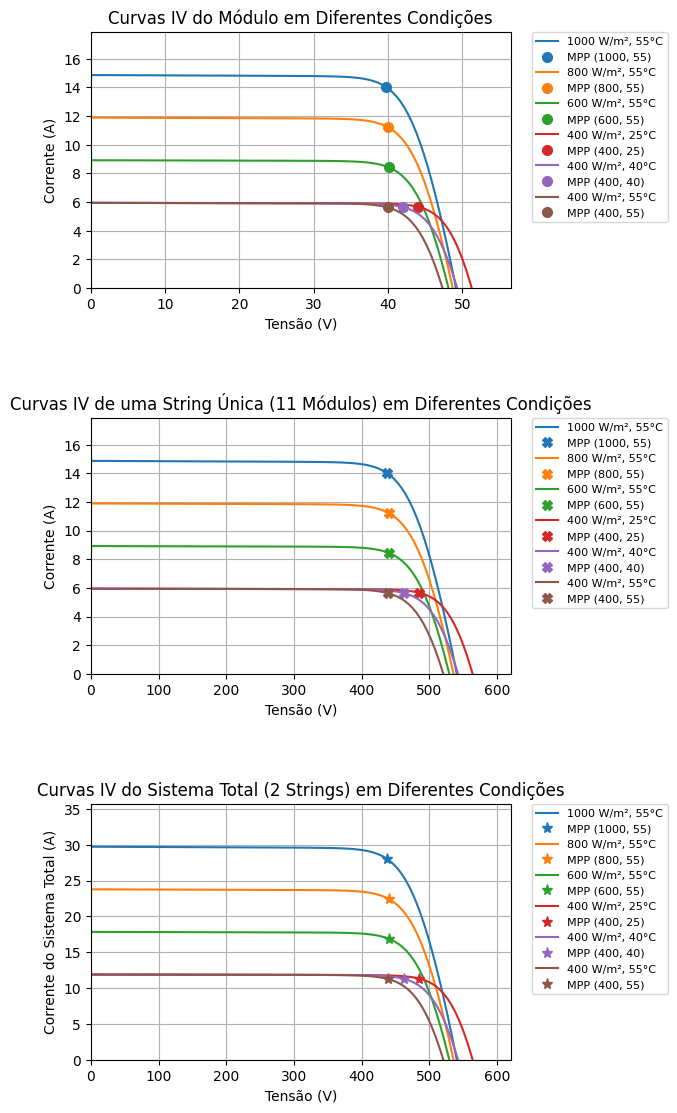


--- Pontos-Chave da Curva IV (Módulo, String Única e Sistema Total) ---


,Type,Irradiance (W/m²),Temp Cell (°C),Voc (V),Isc (A),Vmp (V),Imp (A),Pmp (W)
0,Module,1000,55,49.155727,14.865541,39.777238,14.016488,557.537170
1,Single String,1000,55,540.712994,14.865541,437.549617,14.016488,6132.908868
2,Total System,1000,55,540.712994,29.731083,437.549617,28.032976,12265.817736
3,Module,800,55,48.713785,11.893754,39.985764,11.228178,448.967264
4,Single String,800,55,535.851635,11.893754,439.843404,11.228178,4938.639909
5,Total System,800,55,535.851635,23.787508,439.843404,22.456355,9877.279818
6,Module,600,55,48.144023,8.921306,40.075602,8.430770,337.868193
7,Single String,600,55,529.584254,8.921306,440.831617,8.430770,3716.550124
8,Total System,600,55,529.584254,17.842612,440.831617,16.861541,7433.100249
9,Module,400,25,51.280946,5.942679,44.081921,5.666111,249.773048


In [3]:
# Generate IV curve for STC conditions
from pvlib import pvsystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.temperature import sapm_cell # Import sapm_cell from temperature
import matplotlib.pyplot as plt # Import matplotlib
import numpy as np
from scipy.optimize import newton # Import newton solver
import pandas as pd # Import pandas

# --- Configure System for IV Plotting Manually ---
# Please enter the number of modules per string and the number of strings for the IV curve plots below:
modules_per_string_iv = 11 # <--- EDITAR: Número de módulos por string para os gráficos IV
strings_per_inverter_iv = 2 # <--- EDITAR: Número de strings em paralelo para os gráficos IV
# -------------------------------------------------

num_modulos_total_iv = modules_per_string_iv * strings_per_inverter_iv # Total modules for this IV config

# Get module parameters (using module_parameters as defined in nCr6JUAWi5N2)
# Attempt to access module_parameters dictionary from executing cell nCr6JUAWi5N2 global scope.
try:
    module_parameters_iv = module_parameters # Use module_parameters defined in nCr6JUAWi5N2
    print("Successfully accessed module parameters from previous execution.")
except NameError:
    print("Could not access module parameters from previous execution. Using default module parameters.")
    # Define default module parameters if not available
    module_parameters_iv = {
        'alpha_sc': 0.00046, 'beta_oc': -0.0025, 'gamma_r': -0.0029, 'a_ref': 1.8,
        'I_L_ref': 14.86, 'I_o_ref': 2.5e-12, 'R_s': 0.25, 'R_sh_ref': 450.0,
        'cells_in_series': 132, 'STC': 605, 'V_oc_ref': 48.0, 'I_sc_ref': 14.86,
        'V_mp_ref': 45.0, 'Imp_ref': 13.44
    }

print(f"Plotting IV curves for manually configured system: Modules per String={modules_per_string_iv}, Number of Strings={strings_per_inverter_iv} (Total Modules={num_modulos_total_iv})")

# Define the conditions to plot (irradiance, cell temperature)
cases = [
    (1000, 55),
    (800, 55),
    (600, 55),
    (400, 25),
    (400, 40),
    (400, 55)
]

# Function to solve the single diode equation for current (I) given voltage (V)
def single_diode_equation(I, V, I_L, I_o, R_s, R_sh, nNsVth):
    return I_L - I_o * (np.exp((V + I * R_s) / nNsVth) - 1) - (V + I * R_s) / R_sh - I

# List to store key points for each case (single module, single string, and system)
key_points_list = []

# Create a single figure with subplots for Module, Single String, and System IV curves
# Arrange subplots vertically
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.8, 3.9 * 3)) # 3 rows, 1 column, height scaled by 3
# Ensure axes are a flat array for easy iteration if ncols > 1
axes = axes.flatten()

# Set titles for the subplots
axes[0].set_title('Curvas IV do Módulo em Diferentes Condições')
axes[1].set_title(f'Curvas IV de uma String Única ({modules_per_string_iv} Módulos) em Diferentes Condições')
axes[2].set_title(f'Curvas IV do Sistema Total ({strings_per_inverter_iv} Strings) em Diferentes Condições')

for irradiance, temp_cell in cases:
    # --- Curva IV do Módulo Único ---
    # Calculate single diode model parameters for the given conditions (single module)
    # Use module_parameters_iv which is pulled from nCr6JUAWi5N2 or defaults
    params_module = pvsystem.calcparams_desoto(
        effective_irradiance=irradiance,
        temp_cell=temp_cell,
        alpha_sc=module_parameters_iv['alpha_sc'],
        a_ref=module_parameters_iv['a_ref'],
        I_L_ref=module_parameters_iv['I_L_ref'],
        I_o_ref=module_parameters_iv['I_o_ref'],
        R_s=module_parameters_iv['R_s'],
        R_sh_ref=module_parameters_iv['R_sh_ref'],
        EgRef=1.121, # Band gap energy for Si at 25C, common value
    )

    # Unpack parameters for single module
    I_L_m, I_o_m, R_s_m, R_sh_m, nNsVth_m = params_module

    # Calculate key points for single module using pvsystem.singlediode
    try:
        key_points_m = pvsystem.singlediode(
            photocurrent=I_L_m,
            saturation_current=I_o_m,
            resistance_series=R_s_m,
            resistance_shunt=R_sh_m,
            nNsVth=nNsVth_m,
            method='lambertw'
        )
        voc_m = key_points_m['v_oc']
        isc_m = key_points_m['i_sc']

        # Store key points
        key_points_list.append({
            'Type': 'Module',
            'Irradiance (W/m²)': irradiance,
            'Temp Cell (°C)': temp_cell,
            'Voc (V)': key_points_m['v_oc'],
            'Isc (A)': key_points_m['i_sc'],
            'Vmp (V)': key_points_m['v_mp'],
            'Imp (A)': key_points_m['i_mp'],
            'Pmp (W)': key_points_m['p_mp']
        })

    except Exception as e:
        print(f"Não foi possível calcular os pontos-chave para o módulo único na irradiação {irradiance} e temperatura {temp_cell}: {e}")
        # Fallback for Voc estimation if singlediode fails
        voc_m = module_parameters_iv['V_oc_ref'] * (1 + module_parameters_iv['beta_oc'] * (temp_cell - 25)) * (irradiance/1000)**0.1 # Very rough estimation
        isc_m = module_parameters_iv['I_sc_ref'] * (irradiance/1000) * (1 + module_parameters_iv['alpha_sc'] * (temp_cell - 25)) # Rough estimation
        # Store placeholder key points for single module
        key_points_list.append({
            'Type': 'Module',
            'Irradiance (W/m²)': irradiance,
            'Temp Cell (°C)': temp_cell,
            'Voc (V)': voc_m,
            'Isc (A)': isc_m,
            'Vmp (V)': np.nan,
            'Imp (A)': np.nan,
            'Pmp (W)': np.nan
        })

    # Generate voltage points for single module from 0 to Voc
    v_m = np.linspace(0, voc_m * 1.05, 100) # Go slightly beyond estimated Voc

    # Calculate current points for single module by numerically solving the single diode equation
    i_m = np.zeros_like(v_m)
    for j, voltage in enumerate(v_m):
        try:
            initial_guess_val_m = I_L_m # Use I_L_m as initial guess
            i_m[j] = newton(single_diode_equation, initial_guess_val_m, args=(voltage, I_L_m, I_o_m, R_s_m, R_sh_m, nNsVth_m))
        except Exception:
            i_m[j] = np.nan # Or 0.0
    i_m = np.nan_to_num(i_m, nan=0.0)

    # Plot the IV curve for the single module on the module subplot
    axes[0].plot(v_m, i_m, label=f'{irradiance} W/m², {temp_cell}°C')
    # Plot the MPP as a marker for single module on the module subplot
    if not np.isnan(key_points_list[-1]['Vmp (V)']) and not np.isnan(key_points_list[-1]['Imp (A)']):
        axes[0].plot(key_points_list[-1]['Vmp (V)'], key_points_list[-1]['Imp (A)'], 'o', color=axes[0].lines[-1].get_color(), markersize=7, label=f'MPP ({irradiance}, {temp_cell})')

    # --- Curva IV de uma String Única (Módulos em Série) ---
    # Adjust single diode model parameters for a string of modules in series
    # Use the manually defined number of modules per string for IV plotting
    I_L_s = I_L_m
    I_o_s = I_o_m
    R_s_s = R_s_m * modules_per_string_iv
    # A simplified approach for R_sh scaling; a more detailed model would be better
    R_sh_s = R_sh_m * modules_per_string_iv # Simple linear scaling
    nNsVth_s = nNsVth_m * modules_per_string_iv # Scales with total cells in series

    # Calculate key points for string using pvsystem.singlediode
    try:
        key_points_s = pvsystem.singlediode(
            photocurrent=I_L_s,
            saturation_current=I_o_s,
            resistance_series=R_s_s,
            resistance_shunt=R_sh_s,
            nNsVth=nNsVth_s,
            method='lambertw'
        )
        voc_s = key_points_s['v_oc']
        isc_s = key_points_s['i_sc'] # Use this more reliable Isc for scaling

        # Store key points for single string
        key_points_list.append({
            'Type': 'Single String',
            'Irradiance (W/m²)': irradiance,
            'Temp Cell (°C)': temp_cell,
            'Voc (V)': key_points_s['v_oc'],
            'Isc (A)': key_points_s['i_sc'],
            'Vmp (V)': key_points_s['v_mp'],
            'Imp (A)': key_points_s['i_mp'],
            'Pmp (W)': key_points_s['p_mp']
        })

    except Exception as e:
        print(f"Não foi possível calcular os pontos-chave para a string única na irradiação {irradiance} e temperatura {temp_cell}: {e}")
        # Fallback for Voc estimation
        voc_s = voc_m * modules_per_string_iv # Simple voltage scaling
        isc_s = isc_m # Fallback Isc from module calculation
        # Store placeholder key points for single string
        key_points_list.append({
            'Type': 'Single String',
            'Irradiance (W/m²)': irradiance,
            'Temp Cell (°C)': temp_cell,
            'Voc (V)': voc_s,
            'Isc (A)': isc_s,
            'Vmp (V)': np.nan,
            'Imp (A)': np.nan,
            'Pmp (W)': np.nan
        })

    # Generate voltage points for single string from 0 to Voc
    v_s = np.linspace(0, voc_s * 1.05, 100) # Go slightly beyond estimated Voc

    # Calculate current points for single string by numerically solving the single diode equation
    i_s = np.zeros_like(v_s)
    for j, voltage in enumerate(v_s):
        try:
            initial_guess_val_s = I_L_s # Use I_L_s as initial guess
            i_s[j] = newton(single_diode_equation, initial_guess_val_s, args=(voltage, I_L_s, I_o_s, R_s_s, R_sh_s, nNsVth_s))
        except Exception:
            i_s[j] = np.nan # Or 0.0
    i_s = np.nan_to_num(i_s, nan=0.0)

    # Plot the IV curve for the single string on the string subplot
    axes[1].plot(v_s, i_s, label=f'{irradiance} W/m², {temp_cell}°C')
    # Plot the MPP as a marker for single string on the string subplot
    if not np.isnan(key_points_list[-1]['Vmp (V)']) and not np.isnan(key_points_list[-1]['Imp (A)']):
        axes[1].plot(key_points_list[-1]['Vmp (V)'], key_points_list[-1]['Imp (A)'], 'X', color=axes[1].lines[-1].get_color(), markersize=7, label=f'MPP ({irradiance}, {temp_cell})') # Use 'X' marker for single string MPP

    # --- Curva IV do Sistema Total (Strings em Paralelo) ---
    # The voltage range for the total system is the same as a single string.
    v_sys = v_s
    # The total system current is the sum of currents from all parallel strings.
    # Assuming all strings are identical and under the same conditions, total current = single string current * number of strings
    # Use the manually defined number of strings for IV plotting
    i_sys = i_s * strings_per_inverter_iv

    # Calculate key points for the total system (by scaling single string key points)
    try:
        key_points_sys = {
            'v_oc': key_points_s['v_oc'], # Voc remains the same in parallel
            'i_sc': key_points_s['i_sc'] * strings_per_inverter_iv, # Isc scales linearly
            'v_mp': key_points_s['v_mp'], # Vmp remains the same in parallel (ideally)
            'i_mp': key_points_s['i_mp'] * strings_per_inverter_iv, # Imp scales linearly (ideally)
            'p_mp': key_points_s['p_mp'] * strings_per_inverter_iv # Pmp scales linearly (ideally)
        }

        # Store key points for total system
        key_points_list.append({
            'Type': 'Total System',
            'Irradiance (W/m²)': irradiance,
            'Temp Cell (°C)': temp_cell,
            'Voc (V)': key_points_sys['v_oc'],
            'Isc (A)': key_points_sys['i_sc'],
            'Vmp (V)': key_points_sys['v_mp'],
            'Imp (A)': key_points_sys['i_mp'],
            'Pmp (W)': key_points_sys['p_mp']
        })

    except Exception as e:
        print(f"Não foi possível calcular os pontos-chave para o sistema total na irradiação {irradiance} e temperatura {temp_cell}: {e}")
        # Store placeholder key points for total system
        key_points_list.append({
            'Type': 'Total System',
            'Irradiance (W/m²)': irradiance,
            'Temp Cell (°C)': temp_cell,
            'Voc (V)': np.nan, 'Isc (A)': np.nan, 'Vmp (V)': np.nan, 'Imp (A)': np.nan, 'Pmp (W)': np.nan
        })

    # Plot the IV curve for the total system on the system subplot
    axes[2].plot(v_sys, i_sys, label=f'{irradiance} W/m², {temp_cell}°C')
    # Plot the MPP as a marker for total system on the system subplot
    if not np.isnan(key_points_list[-1]['Vmp (V)']) and not np.isnan(key_points_list[-1]['Imp (A)']):
        axes[2].plot(key_points_list[-1]['Vmp (V)'], key_points_list[-1]['Imp (A)'], '*', color=axes[2].lines[-1].get_color(), markersize=8, label=f'MPP ({irradiance}, {temp_cell})') # Use '*' marker for system MPP

# Configure axes for each subplot
# Adjust y-axis limit for module plot based on maximum Isc
max_current_module = max([kp['Isc (A)'] for kp in key_points_list if kp['Type'] == 'Module' and not np.isnan(kp['Isc (A)'])]) if any(kp['Type'] == 'Module' for kp in key_points_list) else module_parameters_iv['I_sc_ref']
axes[0].set_ylim(bottom=0, top=max_current_module * 1.2) # Set upper limit based on max Isc + 20% buffer
axes[0].set_xlim(left=0)
axes[0].set_xlabel('Tensão (V)') # Set xlabel for the module subplot
axes[0].set_ylabel('Corrente (A)') # Set ylabel for module subplot
axes[0].grid(True)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10 * 0.8)

# Adjust y-axis limit for single string plot (should be the same Isc range as module)
axes[1].set_ylim(bottom=0, top=max_current_module * 1.2) # Same current range as module
# Adjust x-axis limit based on maximum Voc (will be for a single string)
max_voc_string = max([kp['Voc (V)'] for kp in key_points_list if kp['Type'] == 'Single String' and not np.isnan(kp['Voc (V)'])]) if any(kp['Type'] == 'Single String' for kp in key_points_list) else module_parameters_iv['V_oc_ref'] * modules_per_string_iv

axes[1].set_xlim(left=0, right=max_voc_string * 1.1) # Set upper limit based on max Voc for string + 10% buffer
axes[1].set_xlabel('Tensão (V)') # Set xlabel for the single string subplot
axes[1].set_ylabel('Corrente (A)') # Set ylabel for single string subplot
axes[1].grid(True)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10 * 0.8)

# Adjust y-axis limit for total system plot (will scale with number of strings)
max_current_system = max([kp['Isc (A)'] for kp in key_points_list if kp['Type'] == 'Total System' and not np.isnan(kp['Isc (A)'])]) if any(kp['Type'] == 'Total System' for kp in key_points_list) else (max_current_module if not np.isnan(max_current_module) else module_parameters_iv['I_sc_ref']) * strings_per_inverter_iv

axes[2].set_ylim(bottom=0, top=max_current_system * 1.2) # Set upper limit based on max system Isc + 20% buffer
# X-axis limit for total system plot is the same as single string
axes[2].set_xlim(left=0, right=max_voc_string * 1.1)
axes[2].set_xlabel('Tensão (V)') # Set xlabel for the bottom subplot
axes[2].set_ylabel('Corrente do Sistema Total (A)') # Set ylabel for total system subplot
axes[2].grid(True)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10 * 0.8)

# Adjust spacing between subplots and display the figure
plt.subplots_adjust(hspace=3.0) # Increased vertical spacing between subplots
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()

# Display the key points in a pandas DataFrame
key_points_df = pd.DataFrame(key_points_list)
print("\n--- Pontos-Chave da Curva IV (Módulo, String Única e Sistema Total) ---")
display(key_points_df)

In [ ]:
!pip install pvlib pandas numpy

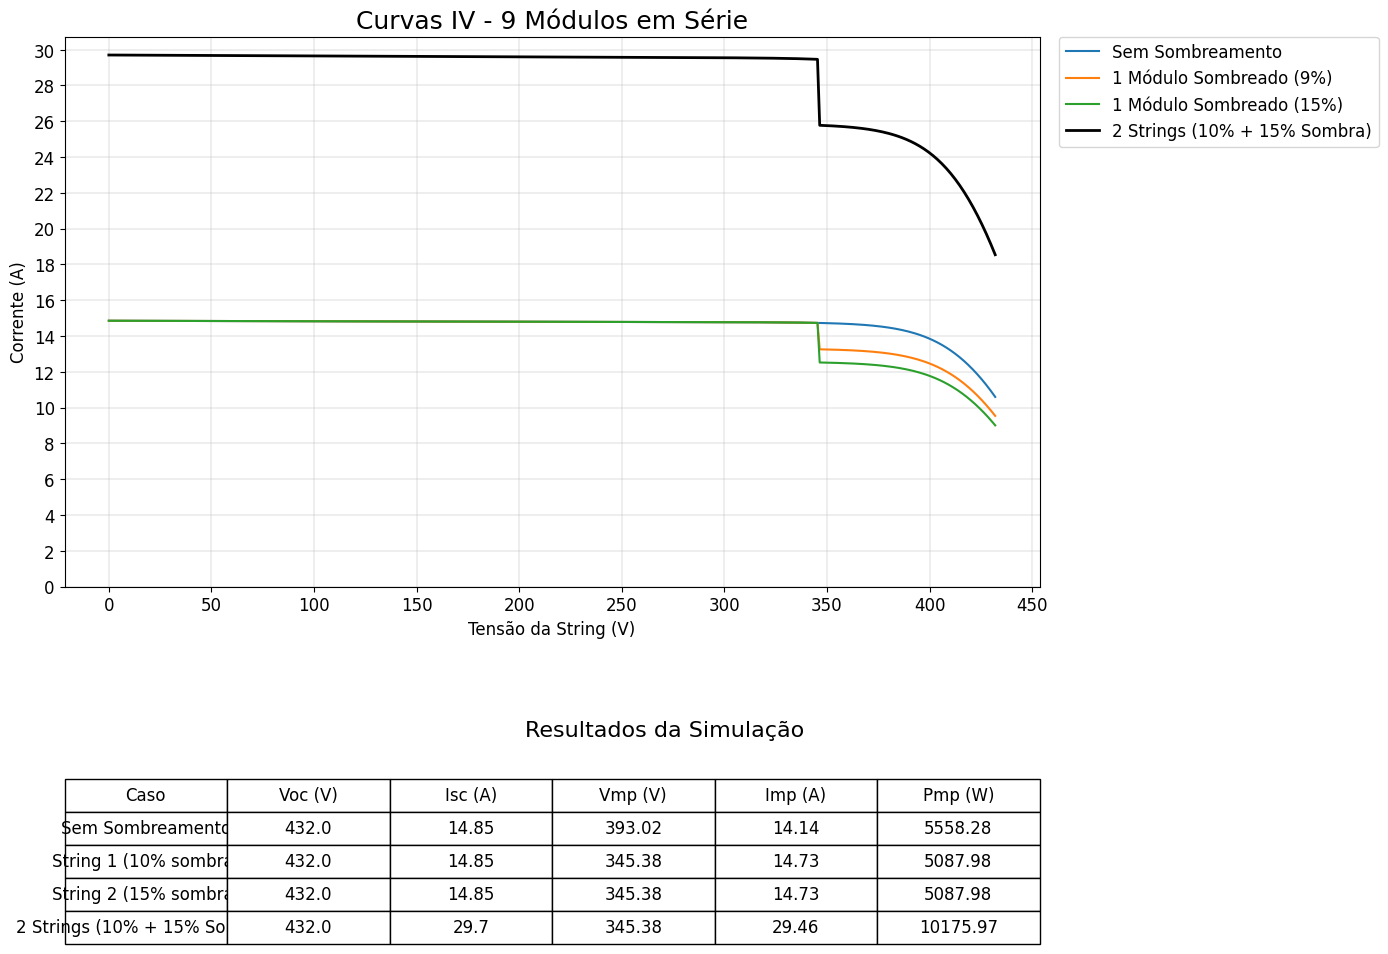

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib import pvsystem

# ============================================================
# PARÂMETROS DO SISTEMA
# ============================================================
module_params = {
    'cells_in_series': 132,
    'I_L_ref': 14.86,
    'I_o_ref': 2.5e-12,
    'R_s': 0.25,
    'R_sh_ref': 450.0,
    'a_ref': 1.8,
    'alpha_sc': 0.00046,
    'V_oc_ref': 48.0,
    'I_sc_ref': 14.86,
    'V_mp_ref': 45.0,
    'Imp_ref': 13.44,
    'Pmp': 605,
    'DTC': 3.0
}

# Configuração do sistema
num_modulos = 18       # total de módulos
modules_per_string_pref = 9    # módulos em série por string
strings_per_inverter = 2      # strings por MPPT

# Simulação
n_points = 400                    # Número de pontos para calcular a curva IV.
use_uniform = True                # Habilita/desabilita a simulação de sombreamento uniforme (True/False)
use_one_module = True             # Habilita/desabilita a simulação de 1 módulo sombreado (True/False)
parallel_with_mismatch = True     # Habilita/desabilita a simulação de strings em paralelo com descasamento (True/False)
shading_uniform = 0.85            # Fator de sombreamento uniforme (0.85 = 15% de sombreamento)
shading_one_module = 0.50         # Fator de sombreamento para 1 módulo (0.50 = 50% de sombreamento)
T_celsius = 25                    # Temperatura da célula em graus Celsius
G = 1000                          # Irradiância em W/m² (1000 = Condições Padrão de Teste)

# ============================================================
# FUNÇÃO PARA GERAR CURVA IV (manual)
# ============================================================
def generate_IV_pvlib(params, n_modules=1, G=1000, T_celsius=25, shading_uniform=1.0, shading_one_module=1.0, n_points=400):
    # Calcula parâmetros do diodo
    Il, Io, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        effective_irradiance=G,
        temp_cell=T_celsius,
        I_L_ref=params['I_L_ref'],
        I_o_ref=params['I_o_ref'],
        R_sh_ref=params['R_sh_ref'],
        R_s=params['R_s'],
        a_ref=params['a_ref'],
        alpha_sc=params['alpha_sc']
    )

    # Array de tensão para 1 módulo
    V_module = np.linspace(0, params['V_oc_ref'], n_points)
    # Calcula corrente usando PVlib
    I_module = pvsystem.i_from_v(V_module, Il, Io, Rs, Rsh, nNsVth)

    # Aplica sombreamento
    I_module *= shading_uniform
    if shading_one_module < 1.0:
        idx_knee = int(0.8 * len(V_module))
        I_module[idx_knee:] *= shading_one_module

    # Ajusta para string inteira
    V_string = V_module * n_modules
    I_string = I_module

    return V_string, I_string

# ============================================================
# FUNÇÃO PARA CALCULAR KEYPOINTS
# ============================================================
def calc_keypoints_from_IV(V, I):
    P = V * I
    P_clean = np.nan_to_num(P)
    idx_mp = int(np.nanargmax(P_clean))

    I_for_interp_voc = np.insert(I, 0, 1e-6)
    V_for_interp_voc = np.insert(V, 0, 0)
    Voc = float(np.interp(0, I_for_interp_voc[::-1], V_for_interp_voc[::-1]))

    Isc = float(I[0])

    Vmp = float(V[idx_mp])
    Imp = float(I[idx_mp])
    Pmp = float(P[idx_mp])
    return {'Voc (V)': Voc, 'Isc (A)': Isc, 'Vmp (V)': Vmp, 'Imp (A)': Imp, 'Pmp (W)': Pmp}

# ============================================================
# SIMULAÇÃO
# ============================================================
results = []

# Nova simulação: duas strings com sombreamento diferente
shading_1 = 0.90  # 10% de sombreamento
shading_2 = 0.85  # 15% de sombreamento

# Geração das curvas IV para cada string com sombreamento
V_string_1, I_string_1 = generate_IV_pvlib(module_params, n_modules=modules_per_string_pref, G=G, T_celsius=T_celsius, shading_one_module=shading_1)
results.append({'Caso': f'String 1 (10% sombra)', **calc_keypoints_from_IV(V_string_1, I_string_1)})

V_string_2, I_string_2 = generate_IV_pvlib(module_params, n_modules=modules_per_string_pref, G=G, T_celsius=T_celsius, shading_one_module=shading_2)
results.append({'Caso': f'String 2 (15% sombra)', **calc_keypoints_from_IV(V_string_2, I_string_2)})

# Geração da curva de referência sem sombreamento
V_clear, I_clear = generate_IV_pvlib(module_params, n_modules=modules_per_string_pref, G=G, T_celsius=T_celsius)
results.insert(0, {'Caso': 'Sem Sombreamento', **calc_keypoints_from_IV(V_clear, I_clear)})

# Combinação das duas strings em paralelo
V_common_shading = np.linspace(max(min(V_string_1), min(V_string_2)), min(max(V_string_1), max(V_string_2)), n_points)
I_total = np.nan_to_num(np.interp(V_common_shading, V_string_1, I_string_1)) + np.nan_to_num(np.interp(V_common_shading, V_string_2, I_string_2))
results.append({'Caso': f'2 Strings (10% + 15% Sombra)', **calc_keypoints_from_IV(V_common_shading, I_total)})


# ============================================================
# PLOTAGEM
# ============================================================
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(V_clear, I_clear, label='Sem Sombreamento')
ax.plot(V_string_1, I_string_1, label=f'1 Módulo Sombreado ({int((1-shading_1)*100)}%)')
ax.plot(V_string_2, I_string_2, label=f'1 Módulo Sombreado ({int((1-shading_2)*100)}%)')
ax.plot(V_common_shading, I_total, '-k', linewidth=2, label=f'2 Strings (10% + 15% Sombra)')

ax.set_title(f'Curvas IV - {modules_per_string_pref} Módulos em Série', fontsize=18)
ax.set_xlabel('Tensão da String (V)', fontsize=12)
ax.set_ylabel('Corrente (A)', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.grid(which='both', linestyle='-', linewidth=0.3)
ax.set_xticks(np.arange(0, ax.get_xlim()[1], 50))
ax.set_yticks(np.arange(0, ax.get_ylim()[1], 2))

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)

df = pd.DataFrame(results).round(2)
table_font_size = 12

plt.subplots_adjust(left=0.1, bottom=0.35, right=0.75, top=0.9)

table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='bottom', bbox=[0, -0.65, 1, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(table_font_size)

for key, cell in table.get_celld().items():
    cell.set_height(0.1)

for cell in table.get_celld().values():
    cell.set_text_props(fontsize=table_font_size)

plt.text(0.5, 0.2, 'Resultados da Simulação', transform=fig.transFigure, fontsize=16, ha='center')

plt.show()

In [ ]:
!pip install timezonefinder pytz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.4/479.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 2.0.0
    Uninstalling cffi-2.0.0:
      Successfully uninstalled cffi-2.0.0


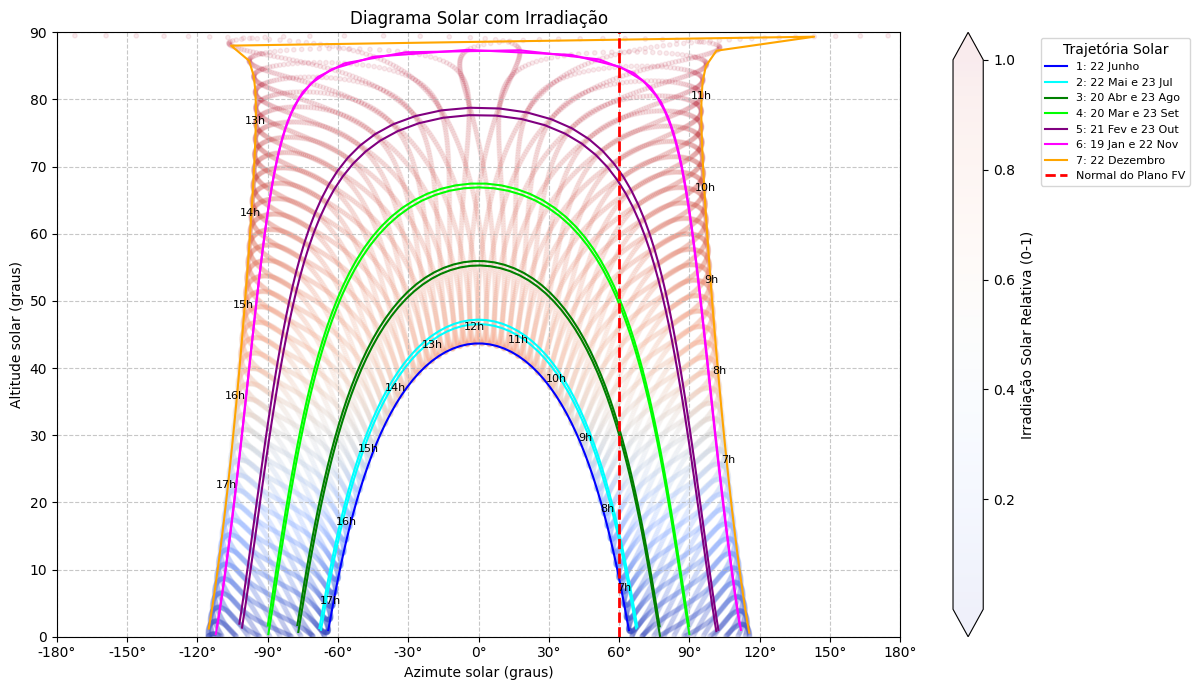

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pvlib import location, solarposition
import pytz

# Função para retornar fuso horário aproximado do Brasil
def get_brazil_timezone(lat, lon):
    if lon >= -54.0:
        return 'America/Fortaleza'
    elif lon >= -60.0:
        return 'America/Sao_Paulo'
    else:
        return 'America/Porto_Velho'

def plot_sunpath_with_ghi(lat, lon, tilt=16, azimute_fv=287, altitude=0):
    tz_str = get_brazil_timezone(lat, lon)
    tz = pytz.timezone(tz_str)

    site = location.Location(lat, lon, tz=tz, altitude=altitude)

    # Datas de todo o ano, 10 min de intervalo
    times = pd.date_range('2020-01-01', '2020-12-31 23:50', freq='10min', tz=tz)

    # Posição solar usando SPA completo
    solpos = site.get_solarposition(times, method='nrel_numpy')

    # GERAÇÃO DE DADOS DE IRRADIAÇÃO SINTÉTICOS PARA DEMONSTRAÇÃO
    irradiance = np.cos(np.deg2rad(90 - solpos['apparent_elevation'])) * 1000
    irradiance[irradiance < 0] = 0
    irradiance_norm = irradiance / irradiance.max()

    # Normalização do azimute para o formato -180 a 180
    azimuth_norm = solpos['azimuth'].copy()
    azimuth_norm[azimuth_norm > 180] -= 360

    # Figura
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plotagem dos pontos de irradiação como um mapa de calor
    sc = ax.scatter(azimuth_norm[solpos['apparent_elevation'] > 0],
                    solpos['apparent_elevation'][solpos['apparent_elevation'] > 0],
                    c=irradiance_norm[solpos['apparent_elevation'] > 0],
                    cmap='coolwarm', s=10, alpha=0.08, zorder=1)

    # Adicionando a barra de cores para a irradiação
    cbar = plt.colorbar(sc, ax=ax, label='Irradiação Solar Relativa (0-1)', extend='both')

    # Estações (as 7 linhas do PVsyst)
    estacoes = {
        '1: 22 Junho': '2020-06-22',
        '2: 22 Mai e 23 Jul': ['2020-05-22', '2020-07-23'],
        '3: 20 Abr e 23 Ago': ['2020-04-20', '2020-08-23'],
        '4: 20 Mar e 23 Set': ['2020-03-20', '2020-09-23'],
        '5: 21 Fev e 23 Out': ['2020-02-21', '2020-10-23'],
        '6: 19 Jan e 22 Nov': ['2020-01-19', '2020-11-22'],
        '7: 22 Dezembro': '2020-12-22'
    }

    # Definição de cores para cada linha
    cores_linhas = ['blue', 'cyan', 'green', 'lime', 'purple', 'magenta', 'orange']
    estacoes_plotadas = []

    for idx, (legenda, datas) in enumerate(estacoes.items()):
        if not isinstance(datas, list):
            datas = [datas]

        cor_da_linha = cores_linhas[idx]

        for data in datas:
            data_ts = pd.Timestamp(data, tz=tz)
            times_est = pd.date_range(data_ts, periods=24*6, freq='10min', tz=tz)
            sol_est = site.get_solarposition(times_est, method='nrel_numpy')
            mask_sun = sol_est['apparent_elevation'] > 0

            az = sol_est.loc[mask_sun, 'azimuth']
            az[az > 180] -= 360
            el = sol_est.loc[mask_sun, 'apparent_elevation']

            if legenda not in estacoes_plotadas:
                ax.plot(az, el, color=cor_da_linha, lw=1.5, label=legenda, zorder=2)
                estacoes_plotadas.append(legenda)
            else:
                ax.plot(az, el, color=cor_da_linha, lw=1.5, zorder=2)

            # Adicionar horários somente para as linhas de Verão e Inverno
            if legenda in ['1: 22 Junho', '7: 22 Dezembro']:
                for hora in range(7, 18):
                    t_point = pd.Timestamp(f"{data} {hora:02d}:00", tz=tz)
                    sol_point = site.get_solarposition(pd.DatetimeIndex([t_point]), method='nrel_numpy')

                    el_value = sol_point['apparent_elevation'].iloc[0]
                    if el_value > 0:
                        az_point = sol_point['azimuth'].iloc[0]
                        if az_point > 180:
                            az_point -= 360

                        if el_value < 85:
                            ax.text(az_point, el_value + 2, f"{hora}h", fontsize=8, ha='center', color='black', zorder=3)

    # Campo de visão FV
    azimute_fv_norm = azimute_fv
    if azimute_fv_norm > 180:
        azimute_fv_norm -= 360

    ax.plot([azimute_fv_norm, azimute_fv_norm], [0, 90], 'r--', lw=2, label='Normal do Plano FV', zorder=2)

    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 90)
    ax.set_xticks(np.arange(-180, 181, 30))
    ax.set_xticklabels([f"{x}°" for x in np.arange(-180, 181, 30)])
    ax.set_xlabel("Azimute solar (graus)")
    ax.set_ylabel("Altitude solar (graus)")
    ax.set_title("Diagrama Solar com Irradiação")
    ax.grid(True, linestyle='--', alpha=0.7)

    leg = ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1), fontsize=8, title='Trajetória Solar')

    plt.tight_layout()
    plt.show()

# ===== Exemplo Rio de Janeiro =====
latitude = -22.911014
longitude = -43.209373
inclinacao = 16
azimute = 60

plot_sunpath_with_ghi(latitude, longitude, tilt=inclinacao, azimute_fv=azimute)

In [ ]:
!pip install pvlib

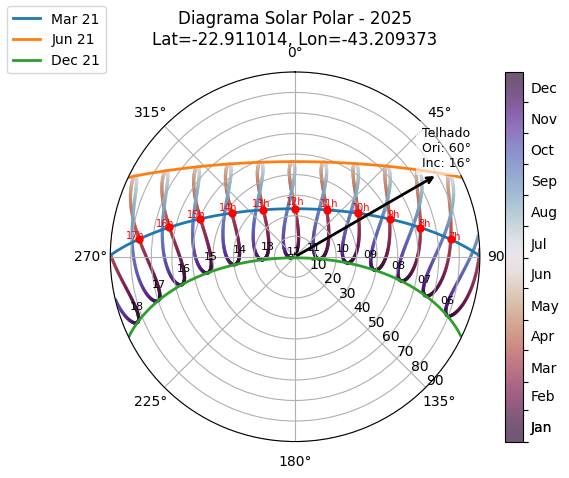

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pvlib import solarposition
import pytz

# ======================================================
# ======== PARÂMETROS EDITÁVEIS PELO USUÁRIO ===========
# ======================================================
TZ = 'America/Sao_Paulo'
#lat, lon = -22.841432, -51.957627 #Colorado
#lat, lon = -8.749453, -63.873544 #porto velho
#lat, lon = -8.058493, -34.884819 #recife
#lat, lon = -15.775446, -47.797089 #brasilia
#lat, lon = -15.598669, -56.099130 #cuiabá
#lat, lon = -3.131633, -59.982504 #manaus
#lat, lon = -30.032500, -51.230377 #porto alegre
lat, lon = -22.911014, -43.209373 #rio de janeiro
#lat, lon = -27.597300, -48.549610 #florianópolis
#lat, lon = -20.812585, -49.380421 #são josé do rio preto
#lat, lon = 2.820848, -60.671958 #boa vista
ANO = 2025

# ======================================================
# ======== PARÂMETROS DO TELHADO =======================
# ======================================================
roof_azimuth_deg = 60 #Orientação do telhado
roof_tilt_deg = 16 #Inclinação do telhado

# Série temporal de 1 ano, resolução horária
times = pd.date_range(f'{ANO}-01-01 00:00:00',
                      f'{ANO+1}-01-01',
                      freq='h', tz=TZ)

# Calcula posição solar
solpos = solarposition.get_solarposition(times, lat, lon)

# Remove horários noturnos
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

# ====== PLOT POLAR ======
ax = plt.subplot(1, 1, 1, projection='polar')

# === CÓDIGO RESTAURADO: Dispersão colorida (analema ao longo do ano) ===
points = ax.scatter(np.radians(solpos.azimuth),
                    solpos.apparent_zenith,  # usamos zenith = 90 - elevação
                    s=2, c=solpos.index.dayofyear,
                    cmap='twilight_shifted_r', alpha=0.7)

# Barra de cores com meses
cbar = ax.figure.colorbar(points)
times_ticks = pd.date_range(f'{ANO}-01-01', f'{ANO+1}-01-01',
                             freq='MS', tz=TZ)
cbar.set_ticks(ticks=times_ticks.dayofyear, labels=[], minor=False)
cbar.set_ticks(ticks=times_ticks.dayofyear+15,
                labels=times_ticks.strftime('%b'),
                minor=True)
cbar.ax.tick_params(which='minor', width=0)

# ====== RÓTULOS DE HORÁRIO (gerais) ======
for hour in np.unique(solpos.index.hour):
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']),
            pos['apparent_zenith'],
            str(hour).zfill(2),
            ha='center', va='bottom', fontsize=8)

# ====== TRAJETÓRIAS DE DIAS TÍPICOS ======
for date in pd.to_datetime([f'{ANO}-03-21',
                             f'{ANO}-06-21',
                             f'{ANO}-12-21']):
    times_day = pd.date_range(date, date+pd.Timedelta('24h'),
                              freq='5min', tz=TZ)
    sol_day = solarposition.get_solarposition(times_day, lat, lon)
    sol_day = sol_day.loc[sol_day['apparent_elevation'] > 0, :]
    label = date.strftime('%b %d')
    ax.plot(np.radians(sol_day.azimuth), sol_day.apparent_zenith,
             label=label, lw=2)

# ====== PONTOS VERMELHOS COM HORÁRIOS (Equinócio de março) ======
date = pd.Timestamp(f'{ANO}-03-21', tz=TZ)
for hora in range(7, 18):
    t_point = pd.Timestamp(f"{ANO}-03-21 {hora:02d}:00:00", tz=TZ)
    sol_point = solarposition.get_solarposition(pd.DatetimeIndex([t_point]), lat, lon).iloc[0]
    if sol_point['apparent_elevation'] > 0:
        az = np.radians(sol_point['azimuth'])
        zen = sol_point['apparent_zenith']
        ax.plot(az, zen, 'ro', markersize=5)
        ax.text(az, zen+2, f"{hora}h", color='red', fontsize=7, ha='center')

# ====== PLOTANDO O TELHADO NO DIAGRAMA ================
roof_azimuth_rad = np.radians(roof_azimuth_deg)

ax.annotate("",
            xy=(roof_azimuth_rad, 80),
            xytext=(roof_azimuth_rad, 0),
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=2))

ax.text(roof_azimuth_rad, 85,
        f"Telhado\nOri: {roof_azimuth_deg}°\nInc: {roof_tilt_deg}°",
        ha='center', va='bottom', fontsize=9, color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# ====== AJUSTES DO GRÁFICO ======
ax.figure.legend(loc='upper left')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)
ax.set_rlabel_position(135)
ax.set_title(f"Diagrama Solar Polar - {ANO}\nLat={lat}, Lon={lon}", pad=20)

plt.show()

In [ ]:
pip install numpy_financial

Somas após ajuste (usando os alvos declarados):
 - Geração anual (ano1. soma meses): 171.500.00 kWh
 - Consumo anual (soma meses): 76.100.00 kWh
 - CAPEX: R$ 280.000.00

==== Comparativo de Custo de Abatimento (Ano 1) ====
 - Custo FIO B não compensado (Grupo B): R$ 3.737.81
 - Custo Tarifa de Disponibilidade: R$ 1.008.00
 - Valor usado nos cálculos do Grupo B (o maior): R$ 3.737.81

--- Fator de Simultaneidade usado na Análise Principal: 25.0% --- (Nova Lógica)

==== RESUMO FINANCEIRO COMPLETO (LOCAL + REMOTO) ====
 - Valor Presente Líquido (VPL): R$ 1.867.697.54
 - Taxa Interna de Retorno (TIR): 39.62%
 - Índice de Lucratividade (PI): 7.67
 - Payback Simples: 2.92 anos
 - Payback Descontado: 3.41 anos
 - Custo de Energia (LCOE): R$ 0.21/kWh
 - Retorno sobre Investimento (ROI) Simples: 2.476.53%
 - Economia Total Projetada (Nominal): R$ 7.241.339.14
 - Economia Total Projetada (Valor Presente): R$ 2.147.697.54

==== RESUMO DE GERAÇÃO E CONSUMO (ANO 1) ====

[ Geração ]
Geração Anual: 

,Geração (kWh),Percentual Abatido Local (%),Econ. Local (R$),Percentual Abatido Remoto B (%),Econ. Remoto B (R$),Percentual Abatido A Verde FP (%),Percentual Abatido A Verde P (%),Econ. Remoto A Verde FP (R$),Econ. Remoto A Verde P (R$),Percentual Abatido A Azul FP (%),Percentual Abatido A Azul P (%),Econ. Remoto A Azul FP (R$),Econ. Remoto A Azul P (R$),O&M (R$),Economia Total (R$),Fluxo de Caixa Acumulado (Descontado)
Ano,,,,,,,,,,,,,,,,
1,171500,"100,00%","R$60.186,19","100,00%","R$19.424,25","100,00%","100,00%","R$11.476,44","R$3.475,20","0,00%","0,00%","R$0,00","R$0,00","R$4.200,00","R$94.562,08",-1.963314e+05
2,170642,"100,00%","R$64.341,63","100,00%","R$19.988,96","100,00%","100,00%","R$12.451,94","R$3.770,59","0,00%","0,00%","R$0,00","R$0,00","R$4.536,00","R$100.553,12",-1.140122e+05
3,169789,"100,00%","R$68.943,05","100,00%","R$20.509,32","100,00%","100,00%","R$13.510,35","R$4.091,09","0,00%","0,00%","R$0,00","R$0,00","R$4.898,88","R$107.053,82",-3.291832e+04
4,168940,"100,00%","R$74.029,82","100,00%","R$20.973,73","100,00%","100,00%","R$14.658,73","R$4.438,84","0,00%","0,00%","R$0,00","R$0,00","R$5.290,79","R$114.101,12",4.706051e+04
5,168095,"100,00%","R$80.070,61","100,00%","R$21.831,43","100,00%","100,00%","R$15.904,72","R$4.816,14","0,00%","0,00%","R$0,00","R$0,00","R$5.714,05","R$122.622,90",1.266267e+05
6,167255,"100,00%","R$87.548,20","100,00%","R$23.687,10","100,00%","100,00%","R$17.256,63","R$5.225,51","0,00%","0,00%","R$0,00","R$0,00","R$6.171,18","R$133.717,44",2.070025e+05
7,166418,"100,00%","R$95.666,11","100,00%","R$25.700,51","100,00%","100,00%","R$18.723,44","R$5.669,68","0,00%","0,00%","R$0,00","R$0,00","R$6.664,87","R$145.759,73",2.881630e+05
8,165586,"100,00%","R$104.478,75","100,00%","R$27.885,05","100,00%","100,00%","R$20.314,93","R$6.151,60","0,00%","0,00%","R$0,00","R$0,00","R$7.198,06","R$158.830,33",3.700852e+05
9,164758,"100,00%","R$114.045,14","100,00%","R$30.255,28","100,00%","100,00%","R$22.041,70","R$6.674,48","0,00%","0,00%","R$0,00","R$0,00","R$7.773,91","R$173.016,61",4.527477e+05



==== Tabela de Fluxos de Caixa (Nominal e Descontado) ====


,Ano,Fluxo de Caixa (Nominal),Fluxo de Caixa Acumulado (Nominal),Fluxo de Caixa (Descontado),Fluxo de Caixa Acumulado (Descontado)
0,0,-280000.00,-280000.00,-280000.00,-280000.00
1,1,90362.08,-189637.92,83668.59,-196331.41
2,2,96017.12,-93620.80,82319.20,-114012.21
3,3,102154.94,8534.13,81093.88,-32918.32
4,4,108810.33,117344.46,79978.84,47060.51
5,5,116908.85,234253.31,79566.20,126626.71
6,6,127546.26,361799.57,80375.78,207002.49
7,7,139094.86,500894.43,81160.51,288163.00
8,8,151632.27,652526.69,81922.20,370085.20
9,9,165242.70,817769.39,82662.49,452747.69


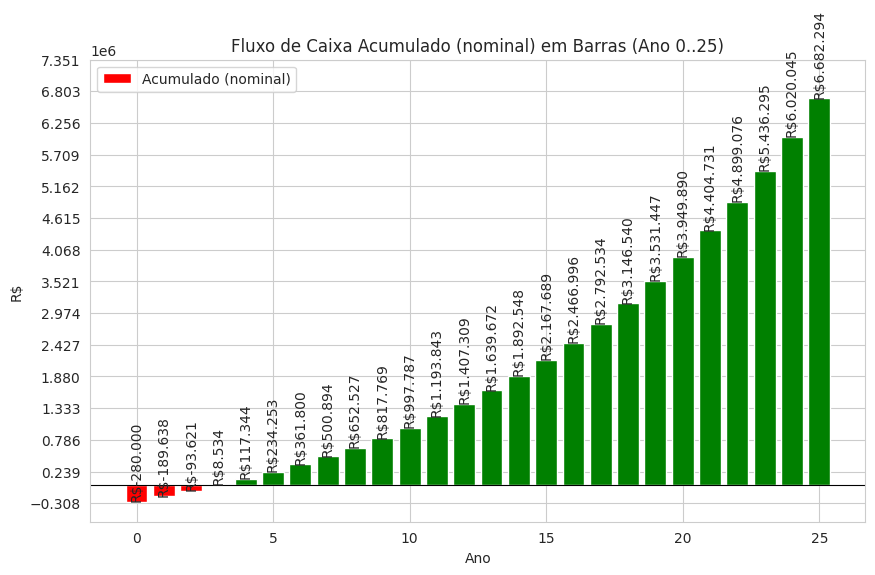

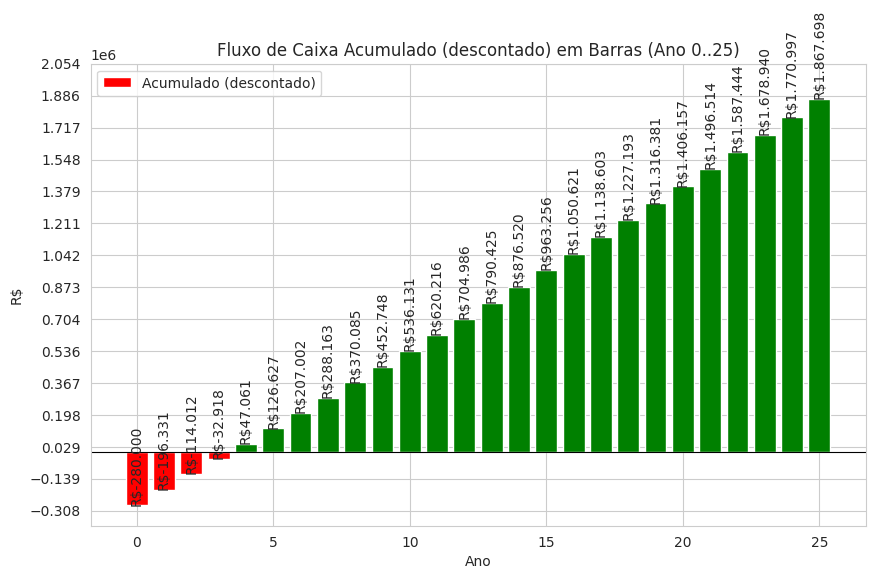

In [ ]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

# =========================================================================
# PARTE 01: ENTRADAS DO USUÁRIO - GERAÇÃO NO GRUPO B
# =========================================================================

# DADOS DO SISTEMA E DO PROJETO
CAPEX = 280000.00
ANOS = 25
SALVAGE_PCT = 0.10  # Valor residual ao final da vida útil
TAXA_DESCONTO = 0.08  # Taxa de desconto anual
INFLACAO_ENERGIA = 0.085  # Inflação anual de energia
OMA_FIRST_PCT = 0.015  # Percentual do CAPEX para O&M no primeiro ano
OMA_INFLACAO = TAXA_DESCONTO # A inflação anual de O&M agora é igual à taxa de desconto

# DADOS DA LEI 14.300 - FIO B
# Cronograma Fio B (percentual NÃO compensado)
FIO_B_SCHEDULE = {2025: 0.45, 2026: 0.60, 2027: 0.75, 2028: 0.90}
BASE_YEAR = 2025
FIO_B_VALOR = 0.25 # R$/kWh (valor ajustado para simulação)

# DADOS DAS UNIDADES CONSUMIDORAS (mensais)
# Atenção: Você deve inserir 12 valores para cada lista (Janeiro a Dezembro)

# Geração Mensal (kWh)
gen_monthly = np.array([12000, 13000, 15000, 16000, 15500, 14000, 13500, 14500, 15000, 16000, 14000, 13000])

# Consumo Local (Geradora - Grupo B)
consumo_local_monthly = np.array([6000, 6200, 6100, 6900, 6800, 6500, 6600, 6400, 6300, 6100, 6000, 6200])
TARIFA_BASE = 0.84 # R$/kWh

# Lógica de seleção da Tarifa de Disponibilidade
TIPO_CONEXAO = "Trifásico" # Escolha: "Trifásico", "Bifásico" ou "Monofásico"
if TIPO_CONEXAO == "Trifásico":
    DEMANDA_MINIMA = 100
elif TIPO_CONEXAO == "Bifásico":
    DEMANDA_MINIMA = 50
elif TIPO_CONEXAO == "Monofásico":
    DEMANDA_MINIMA = 30
else:
    DEMANDA_MINIMA = 0


# Consumo Remoto Grupo B (se houver)
AUTOCONSUMO_REMOTO_B = True
consumo_remoto_b_monthly = np.array([2000, 2100, 2200, 2000, 2900, 2800, 2000, 2100, 2200, 2300, 2100, 2000])
PERC_ABATIMENTO_B = 0.40 # Percentual da geração total para abater o Grupo B

# Consumo Remoto Grupo A Verde (se houver)
AUTOCONSUMO_REMOTO_A_VERDE = True
consumo_remoto_a_verde_foraponta_monthly = np.array([3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000])
consumo_remoto_a_verde_ponta_monthly = np.array([500,500,500,500,500,500,500,500,500,500,500,500])
TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA = 0.48 # R$/kWh
TARIFA_TOTAL_REMOTO_A_VERDE_PONTA = 2.20 # R$/kWh
TUSD_REMOTO_A_VERDE_FORA_PONTA = 0.16121 # R$/kWh
TUSD_REMOTO_A_VERDE_PONTA = 1.6208 # R$/kWh
PERC_ABATIMENTO_A_VERDE = 0.60 # Percentual da geração total para abater o Grupo A Verde

# Consumo Remoto Grupo A Azul (se houver)
AUTOCONSUMO_REMOTO_A_AZUL = False
consumo_remoto_a_azul_foraponta_monthly = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
consumo_remoto_a_azul_ponta_monthly = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA = 0.80 # R$/kWh
TARIFA_TOTAL_REMOTO_A_AZUL_PONTA = 1.50 # R$/kWh
TUSD_REMOTO_A_AZUL_FORA_PONTA = 0.60 # R$/kWh
TUSD_REMOTO_A_AZUL_PONTA = 1.00 # R$/kWh
PERC_ABATIMENTO_A_AZUL = 0.20 # Percentual da geração total para abater o Grupo A Azul

# OUTROS PARÂMETROS
DEGRADACAO = 0.005 # 0.7% ao ano
FATOR_SIMULTANEIDADE = 0.25 # Percentual da geração usada localmente de forma instantânea

# =========================================================================
# PARTE 02: CÁLCULOS
# =========================================================================

# Inicialização de variáveis
anos = np.arange(1, ANOS + 1)
flows = np.zeros(ANOS + 1)
flows[0] = -CAPEX
disc_flows = np.zeros(ANOS + 1)
disc_flows[0] = -CAPEX

# Listas para armazenamento dos resultados anuais
gen_annual = np.zeros(ANOS)
autoconsumo_instantaneo_annual = np.zeros(ANOS)
autoconsumo_abatido_annual = np.zeros(ANOS)
abatido_remoto_b_annual = np.zeros(ANOS)
abatido_remoto_a_verde_foraponta_annual = np.zeros(ANOS)
abatido_remoto_a_verde_ponta_annual = np.zeros(ANOS)
abatido_remoto_a_azul_foraponta_annual = np.zeros(ANOS)
abatido_remoto_a_azul_ponta_annual = np.zeros(ANOS)
economia_geradora_annual = np.zeros(ANOS)
economia_remoto_b_annual = np.zeros(ANOS)
economia_remoto_a_verde_foraponta_annual = np.zeros(ANOS)
economia_remoto_a_verde_ponta_annual = np.zeros(ANOS)
economia_remoto_a_azul_foraponta_annual = np.zeros(ANOS)
economia_remoto_a_azul_ponta_annual = np.zeros(ANOS)
economia_total_annual = np.zeros(ANOS)
oma_annual = np.zeros(ANOS)
pv_gen_annual = np.zeros(ANOS)
pv_oma_annual = np.zeros(ANOS)

# Nova variável para o banco de créditos (em kWh)
banco_creditos = 0

# Loop principal: ano a ano
for idx, ano in enumerate(anos, start=1):

    # Nova variável para o banco de créditos (em kWh)
    banco_creditos_mes_inicial = banco_creditos

    # Inicialização das variáveis mensais para acumular no ano
    autoconsumo_instantaneo_mensal_acumulado = 0
    autoconsumo_abatido_mensal_acumulado = 0
    abatido_remoto_b_mensal_acumulado = 0
    abatido_remoto_a_verde_foraponta_mensal_acumulado = 0
    abatido_remoto_a_verde_ponta_mensal_acumulado = 0
    abatido_remoto_a_azul_foraponta_mensal_acumulado = 0
    abatido_remoto_a_azul_ponta_mensal_acumulado = 0

    # Inflação e degradação
    gen_mes_base = gen_monthly * ((1 - DEGRADACAO) ** (ano - 1))
    tarifa_base_mes = TARIFA_BASE * ((1 + INFLACAO_ENERGIA) ** (idx - 1))

    # Fio B e custos de O&M
    noncomp_b = FIO_B_SCHEDULE.get(BASE_YEAR + (ano - 1), 1.0)
    noncomp_a = 1.0
    fio_b_y = FIO_B_VALOR * ((1 + INFLACAO_ENERGIA) ** (idx - 1))

    # Loop aninhado: mês a mês
    for mes in range(12):

        # Geração e Consumo do Mês
        gen_m = gen_mes_base[mes]
        consumo_local_m = consumo_local_monthly[mes]

        # 1. AUTOCONSUMO LOCAL
        # Autoconsumo Instantâneo (o que não gera crédito nem custo)
        autoconsumo_instantaneo_m = min(gen_m * FATOR_SIMULTANEIDADE, consumo_local_m)

        # Energia injetada na rede
        injetado_m = gen_m - autoconsumo_instantaneo_m

        # Consumo restante a ser abatido (com créditos)
        consumo_restante_local_m = consumo_local_m - autoconsumo_instantaneo_m

        # Abate o consumo restante com a energia injetada no próprio mês
        abatido_com_injetado_m = min(injetado_m, consumo_restante_local_m)

        # Atualiza a energia injetada e o consumo restante
        injetado_liquido_m = injetado_m - abatido_com_injetado_m
        consumo_a_abater_com_creditos_m = consumo_restante_local_m - abatido_com_injetado_m

        # Abate o consumo restante com o banco de créditos
        abatido_com_credito_m = min(consumo_a_abater_com_creditos_m, banco_creditos)
        banco_creditos -= abatido_com_credito_m

        # O total abatido na unidade geradora é a soma do abatido no mês com o abatido do banco de créditos
        autoconsumo_abatido_m = abatido_com_injetado_m + abatido_com_credito_m

        # Atualiza o banco de créditos com o excedente do mês
        banco_creditos += injetado_liquido_m

        # 2. ABATIMENTO DE UNIDADES REMOTAS

        # Créditos disponíveis para as unidades remotas no final do mês
        creditos_disponiveis = banco_creditos * (1 - PERC_ABATIMENTO_B - PERC_ABATIMENTO_A_VERDE - PERC_ABATIMENTO_A_AZUL)

        # Créditos para cada grupo remoto
        creditos_para_b = banco_creditos * PERC_ABATIMENTO_B
        creditos_para_a_verde = banco_creditos * PERC_ABATIMENTO_A_VERDE
        creditos_para_a_azul = banco_creditos * PERC_ABATIMENTO_A_AZUL

        abatido_remoto_b_m = 0
        abatido_remoto_a_verde_foraponta_m = 0
        abatido_remoto_a_verde_ponta_m = 0
        abatido_remoto_a_azul_foraponta_m = 0
        abatido_remoto_a_azul_ponta_m = 0

        if AUTOCONSUMO_REMOTO_B:
            consumo_remoto_b_m = consumo_remoto_b_monthly[mes]
            creditos_b_utilizados = min(creditos_para_b, consumo_remoto_b_m)
            banco_creditos -= creditos_b_utilizados
            abatido_remoto_b_m = creditos_b_utilizados

        if AUTOCONSUMO_REMOTO_A_VERDE:
            consumo_fp_a_verde_m = consumo_remoto_a_verde_foraponta_monthly[mes]
            consumo_p_a_verde_m = consumo_remoto_a_verde_ponta_monthly[mes]

            # Fatores de equivalência mensais
            tarifa_total_remoto_a_verde_fp_m = TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
            tarifa_total_remoto_a_verde_p_m = TARIFA_TOTAL_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
            fator_equiv_b_a_verde_fp = tarifa_base_mes / tarifa_total_remoto_a_verde_fp_m
            fator_equiv_b_a_verde_p = tarifa_base_mes / tarifa_total_remoto_a_verde_p_m

            creditos_restantes = creditos_para_a_verde

            # Prioridade de abatimento: FORA DE PONTA primeiro
            abatido_fp = min(creditos_restantes * fator_equiv_b_a_verde_fp, consumo_fp_a_verde_m)
            creditos_restantes -= abatido_fp / fator_equiv_b_a_verde_fp

            # Em seguida, PONTA
            abatido_p = min(creditos_restantes * fator_equiv_b_a_verde_p, consumo_p_a_verde_m)

            abatido_remoto_a_verde_foraponta_m = abatido_fp
            abatido_remoto_a_verde_ponta_m = abatido_p
            banco_creditos -= (abatido_fp / fator_equiv_b_a_verde_fp) + (abatido_p / fator_equiv_b_a_verde_p)

        if AUTOCONSUMO_REMOTO_A_AZUL:
            consumo_fp_a_azul_m = consumo_remoto_a_azul_foraponta_monthly[mes]
            consumo_p_a_azul_m = consumo_remoto_a_azul_ponta_monthly[mes]

            # Fatores de equivalência mensais
            tarifa_total_remoto_a_azul_fp_m = TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
            tarifa_total_remoto_a_azul_p_m = TARIFA_TOTAL_REMOTO_A_AZUL_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
            fator_equiv_b_a_azul_fp = tarifa_base_mes / tarifa_total_remoto_a_azul_fp_m
            fator_equiv_b_a_azul_p = tarifa_base_mes / tarifa_total_remoto_a_azul_p_m

            creditos_restantes = creditos_para_a_azul

            # Prioridade de abatimento: FORA DE PONTA primeiro
            abatido_fp = min(creditos_restantes * fator_equiv_b_a_azul_fp, consumo_fp_a_azul_m)
            creditos_restantes -= abatido_fp / fator_equiv_b_a_azul_fp

            # Em seguida, PONTA
            abatido_p = min(creditos_restantes * fator_equiv_b_a_azul_p, consumo_p_a_azul_m)

            abatido_remoto_a_azul_foraponta_m = abatido_fp
            abatido_remoto_a_azul_ponta_m = abatido_p
            banco_creditos -= (abatido_fp / fator_equiv_b_a_azul_fp) + (abatido_p / fator_equiv_b_a_azul_p)

        # 3. ACUMULADORES MENSAIS
        autoconsumo_instantaneo_mensal_acumulado += autoconsumo_instantaneo_m
        autoconsumo_abatido_mensal_acumulado += autoconsumo_abatido_m
        abatido_remoto_b_mensal_acumulado += abatido_remoto_b_m
        abatido_remoto_a_verde_foraponta_mensal_acumulado += abatido_remoto_a_verde_foraponta_m
        abatido_remoto_a_verde_ponta_mensal_acumulado += abatido_remoto_a_verde_ponta_m
        abatido_remoto_a_azul_foraponta_mensal_acumulado += abatido_remoto_a_azul_foraponta_m
        abatido_remoto_a_azul_ponta_mensal_acumulado += abatido_remoto_a_azul_ponta_m

    # FIM DO LOOP MENSAL

    # Cálculos Anuais a partir dos acumuladores

    # Geração anual
    gen_annual[idx - 1] = np.sum(gen_mes_base)

    # Abatimento local
    autoconsumo_instantaneo_annual[idx - 1] = autoconsumo_instantaneo_mensal_acumulado
    autoconsumo_abatido_annual[idx - 1] = autoconsumo_abatido_mensal_acumulado

    # Abatimento Remoto
    abatido_remoto_b_annual[idx - 1] = abatido_remoto_b_mensal_acumulado
    abatido_remoto_a_verde_foraponta_annual[idx - 1] = abatido_remoto_a_verde_foraponta_mensal_acumulado
    abatido_remoto_a_verde_ponta_annual[idx - 1] = abatido_remoto_a_verde_ponta_mensal_acumulado
    abatido_remoto_a_azul_foraponta_annual[idx - 1] = abatido_remoto_a_azul_foraponta_mensal_acumulado
    abatido_remoto_a_azul_ponta_annual[idx - 1] = abatido_remoto_a_azul_ponta_mensal_acumulado

    # Cálculo das Economias Anuais

    # Economia Unidade Geradora Local (Grupo B)
    abatido_total_local = autoconsumo_instantaneo_annual[idx - 1] + autoconsumo_abatido_annual[idx-1]

    # Custo de Abatimento Fio B ou Demanda Mínima (o maior)
    custo_fio_b_ano = autoconsumo_abatido_annual[idx - 1] * FIO_B_VALOR * noncomp_b
    custo_disponibilidade_ano = DEMANDA_MINIMA * tarifa_base_mes * 12
    maior_custo_abatimento = max(custo_fio_b_ano, custo_disponibilidade_ano)

    economia_geradora_annual[idx-1] = (abatido_total_local * tarifa_base_mes) - maior_custo_abatimento

    # Economia Unidade Remota Grupo B
    economia_remoto_b_annual[idx-1] = (abatido_remoto_b_annual[idx - 1] * tarifa_base_mes) - (abatido_remoto_b_annual[idx-1] * fio_b_y * noncomp_b)

    # Economia Unidade Remota Grupo A Verde
    tarifa_total_remoto_a_verde_fp_y = TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
    tarifa_total_remoto_a_verde_p_y = TARIFA_TOTAL_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
    tusc_remoto_a_verde_fp_y = TUSD_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
    tusc_remoto_a_verde_p_y = TUSD_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))

    economia_remoto_a_verde_foraponta_annual[idx - 1] = abatido_remoto_a_verde_foraponta_annual[idx-1] * tarifa_total_remoto_a_verde_fp_y - (abatido_remoto_a_verde_foraponta_annual[idx-1] * tusc_remoto_a_verde_fp_y * noncomp_a)
    economia_remoto_a_verde_ponta_annual[idx - 1] = abatido_remoto_a_verde_ponta_annual[idx-1] * tarifa_total_remoto_a_verde_p_y - (abatido_remoto_a_verde_ponta_annual[idx-1] * tusc_remoto_a_verde_p_y * noncomp_a)

    # Economia Unidade Remota Grupo A Azul
    tarifa_total_remoto_a_azul_fp_y = TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
    tarifa_total_remoto_a_azul_p_y = TARIFA_TOTAL_REMOTO_A_AZUL_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
    tusc_remoto_a_azul_fp_y = TUSD_REMOTO_A_AZUL_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))
    tusc_remoto_a_azul_p_y = TUSD_REMOTO_A_AZUL_PONTA * ((1 + INFLACAO_ENERGIA) ** (idx - 1))

    economia_remoto_a_azul_foraponta_annual[idx - 1] = abatido_remoto_a_azul_foraponta_annual[idx-1] * tarifa_total_remoto_a_azul_fp_y - (abatido_remoto_a_azul_foraponta_annual[idx-1] * tusc_remoto_a_azul_fp_y * noncomp_a)
    economia_remoto_a_azul_ponta_annual[idx - 1] = abatido_remoto_a_azul_ponta_annual[idx-1] * tarifa_total_remoto_a_azul_p_y - (abatido_remoto_a_azul_ponta_annual[idx-1] * tusc_remoto_a_azul_p_y * noncomp_a)

    # Economia Total e Fluxo de Caixa
    economia_total_annual[idx - 1] = economia_geradora_annual[idx - 1] + economia_remoto_b_annual[idx-1] + economia_remoto_a_verde_foraponta_annual[idx-1] + economia_remoto_a_verde_ponta_annual[idx-1] + economia_remoto_a_azul_foraponta_annual[idx-1] + economia_remoto_a_azul_ponta_annual[idx-1]

    oma_annual[idx - 1] = CAPEX * OMA_FIRST_PCT * ((1 + OMA_INFLACAO) ** (idx-1))
    flow_y = economia_total_annual[idx - 1] - oma_annual[idx-1]
    if ano == ANOS:
        flow_y += CAPEX * SALVAGE_PCT

    flows[idx] = flow_y
    disc_flows[idx] = flow_y / ((1 + TAXA_DESCONTO)**(idx))

    pv_gen_annual[idx-1] = gen_annual[idx-1] / ((1 + TAXA_DESCONTO)**(idx))
    pv_oma_annual[idx-1] = oma_annual[idx-1] / ((1 + TAXA_DESCONTO)**(idx))

# Cálculo do VPL e do Payback
VPL = npf.npv(TAXA_DESCONTO, flows)
TIR = npf.irr(flows)

# CORREÇÃO DO CÁLCULO DE PAYBACK SIMPLES E DESCONTADO
cumul_nominal = np.cumsum(flows)
cumul_discounted = np.cumsum(disc_flows)

payback_nominal = 0
for i in range(1, len(cumul_nominal)):
    if cumul_nominal[i] >= 0:
        prev_cumul = cumul_nominal[i-1]
        current_flow = flows[i]
        payback_nominal = i - 1 + abs(prev_cumul) / current_flow
        break

payback_descontado = 0
for i in range(1, len(cumul_discounted)):
    if cumul_discounted[i] >= 0:
        prev_cumul_disc = cumul_discounted[i-1]
        current_flow_disc = disc_flows[i]
        payback_descontado = i - 1 + abs(prev_cumul_disc) / current_flow_disc
        break

# NOVOS CÁLCULOS FINANCEIROS
total_pv_economies = np.sum(disc_flows[1:])
pi = total_pv_economies / CAPEX
total_pv_gen = np.sum(pv_gen_annual)
total_pv_oma = np.sum(pv_oma_annual)
lcoe = (CAPEX + total_pv_oma - (CAPEX * SALVAGE_PCT / (1 + TAXA_DESCONTO)**(ANOS))) / total_pv_gen
roi_simples = (np.sum(economia_total_annual) - np.sum(oma_annual)) / CAPEX

# =========================================================================
# PARTE 03: VISUALIZAÇÃO E RESULTADOS
# =========================================================================

# Somas após ajuste (usando os alvos declarados)
print("Somas após ajuste (usando os alvos declarados):")
print(f" - Geração anual (ano1, soma meses): {np.sum(gen_monthly):,.2f} kWh".replace(",", "."))
print(f" - Consumo anual (soma meses): {np.sum(consumo_local_monthly):,.2f} kWh".replace(",", "."))
print(f" - CAPEX: R$ {CAPEX:,.2f}".replace(",", "."))

# Comparativo de custo de abatimento (Ano 1)
print("\n==== Comparativo de Custo de Abatimento (Ano 1) ====")
custo_fio_b_ano1 = autoconsumo_abatido_annual[0] * FIO_B_VALOR * FIO_B_SCHEDULE.get(BASE_YEAR, 1.0)
custo_disponibilidade_ano1 = DEMANDA_MINIMA * TARIFA_BASE * 12
print(f" - Custo FIO B não compensado (Grupo B): R$ {custo_fio_b_ano1:,.2f}".replace(",", "."))
print(f" - Custo Tarifa de Disponibilidade: R$ {custo_disponibilidade_ano1:,.2f}".replace(",", "."))
print(f" - Valor usado nos cálculos do Grupo B (o maior): R$ {max(custo_fio_b_ano1, custo_disponibilidade_ano1):,.2f}".replace(",", "."))

print(f"\n--- Fator de Simultaneidade usado na Análise Principal: {FATOR_SIMULTANEIDADE*100:,.1f}% --- (Nova Lógica)".replace(",", "."))

# Impressão resumo financeiro
print("\n==== RESUMO FINANCEIRO COMPLETO (LOCAL + REMOTO) ====")
print(f" - Valor Presente Líquido (VPL): R$ {VPL:,.2f}".replace(",", "."))
print(f" - Taxa Interna de Retorno (TIR): {TIR*100:,.2f}%".replace(",", "."))
print(f" - Índice de Lucratividade (PI): {pi:,.2f}".replace(",", "."))
print(f" - Payback Simples: {payback_nominal:,.2f} anos".replace(",", "."))
print(f" - Payback Descontado: {payback_descontado:,.2f} anos".replace(",", "."))
print(f" - Custo de Energia (LCOE): R$ {lcoe:,.2f}/kWh".replace(",", "."))
print(f" - Retorno sobre Investimento (ROI) Simples: {roi_simples*100:,.2f}%".replace(",", "."))
print(f" - Economia Total Projetada (Nominal): R$ {np.sum(economia_total_annual):,.2f}".replace(",", "."))
print(f" - Economia Total Projetada (Valor Presente): R$ {total_pv_economies:,.2f}".replace(",", "."))

# Resumo de Geração e Consumo (Ano 1)
print("\n==== RESUMO DE GERAÇÃO E CONSUMO (ANO 1) ====")
CONSUMO_ANUAL_CALCULADO = np.sum(consumo_local_monthly)
CONSUMO_ANUAL_REMOTO_B = np.sum(consumo_remoto_b_monthly)
CONSUMO_ANUAL_FORA_PONTA_A_VERDE = np.sum(consumo_remoto_a_verde_foraponta_monthly)
CONSUMO_ANUAL_PONTA_A_VERDE = np.sum(consumo_remoto_a_verde_ponta_monthly)
CONSUMO_ANUAL_FORA_PONTA_A_AZUL = np.sum(consumo_remoto_a_azul_foraponta_monthly)
CONSUMO_ANUAL_PONTA_A_AZUL = np.sum(consumo_remoto_a_azul_ponta_monthly)

# Geração
print("\n[ Geração ]")
print(f"Geração Anual: {gen_annual[0]:,.2f} kWh".replace(",", "."))

# Consumo Local
print("\n[ Unidade Geradora Local (Grupo B) ]")
print(f"Consumo Local: {CONSUMO_ANUAL_CALCULADO:,.2f} kWh".replace(",", "."))
autoconsumo_total_local = autoconsumo_instantaneo_annual[0] + autoconsumo_abatido_annual[0]
perc_abatido_local = (autoconsumo_total_local / CONSUMO_ANUAL_CALCULADO) * 100 if CONSUMO_ANUAL_CALCULADO > 0 else 0
print(f"Autoconsumo Instantâneo: {autoconsumo_instantaneo_annual[0]:,.2f} kWh".replace(",", "."))
print(f"Consumo Abatido: {autoconsumo_total_local:,.2f} kWh".replace(",", "."))
print(f"Percentual do Consumo Abatido: {perc_abatido_local:,.2f}%".replace(",", "."))

# Grupo B remoto
if AUTOCONSUMO_REMOTO_B:
    print("\n[ Grupo B Remoto ]")
    perc_abatido_b = (abatido_remoto_b_annual[0] / CONSUMO_ANUAL_REMOTO_B) * 100 if CONSUMO_ANUAL_REMOTO_B > 0 else 0
    print(f"Consumo Remoto B: {CONSUMO_ANUAL_REMOTO_B:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Grupo B: {abatido_remoto_b_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Percentual Abatido Grupo B: {perc_abatido_b:,.2f}%".replace(",", "."))

# Grupo A verde remoto
if AUTOCONSUMO_REMOTO_A_VERDE:
    print("\n[ Grupo A Verde Remoto ]")
    perc_abatido_fp_verde = (abatido_remoto_a_verde_foraponta_annual[0] / CONSUMO_ANUAL_FORA_PONTA_A_VERDE) * 100 if CONSUMO_ANUAL_FORA_PONTA_A_VERDE > 0 else 0
    perc_abatido_p_verde = (abatido_remoto_a_verde_ponta_annual[0] / CONSUMO_ANUAL_PONTA_A_VERDE) * 100 if CONSUMO_ANUAL_PONTA_A_VERDE > 0 else 0
    print(f"Consumo Remoto Fora Ponta: {CONSUMO_ANUAL_FORA_PONTA_A_VERDE:,.2f} kWh".replace(",", "."))
    print(f"Consumo Remoto Ponta: {CONSUMO_ANUAL_PONTA_A_VERDE:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Fora Ponta: {abatido_remoto_a_verde_foraponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Ponta: {abatido_remoto_a_verde_ponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Percentual Abatido Fora Ponta: {perc_abatido_fp_verde:,.2f}%".replace(",", "."))
    print(f"Percentual Abatido Ponta: {perc_abatido_p_verde:,.2f}%".replace(",", "."))

# Grupo A azul remoto
if AUTOCONSUMO_REMOTO_A_AZUL:
    print("\n[ Grupo A Azul Remoto ]")
    perc_abatido_fp_azul = (abatido_remoto_a_azul_foraponta_annual[0] / CONSUMO_ANUAL_FORA_PONTA_A_AZUL) * 100 if CONSUMO_ANUAL_FORA_PONTA_A_AZUL > 0 else 0
    perc_abatido_p_azul = (abatido_remoto_a_azul_ponta_annual[0] / CONSUMO_ANUAL_PONTA_A_AZUL) * 100 if CONSUMO_ANUAL_PONTA_A_AZUL > 0 else 0
    print(f"Consumo Remoto Fora Ponta: {CONSUMO_ANUAL_FORA_PONTA_A_AZUL:,.2f} kWh".replace(",", "."))
    print(f"Consumo Remoto Ponta: {CONSUMO_ANUAL_PONTA_A_AZUL:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Fora Ponta: {abatido_remoto_a_azul_foraponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Ponta: {abatido_remoto_a_azul_ponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Percentual Abatido Fora Ponta: {perc_abatido_fp_azul:,.2f}%".replace(",", "."))
    print(f"Percentual Abatido Ponta: {perc_abatido_p_azul:,.2f}%".replace(",", "."))
# ---
# Tabela de Resumo de Economia e Tarifas por ano
# ---

# Criando as colunas de percentual de abatimento
perc_abatido_local_annual = ((autoconsumo_instantaneo_annual + autoconsumo_abatido_annual) / CONSUMO_ANUAL_CALCULADO) * 100 if CONSUMO_ANUAL_CALCULADO > 0 else 0
perc_abatido_remoto_b_annual = (abatido_remoto_b_annual / CONSUMO_ANUAL_REMOTO_B) * 100 if CONSUMO_ANUAL_REMOTO_B > 0 else 0
perc_abatido_remoto_a_verde_fp_annual = (abatido_remoto_a_verde_foraponta_annual / CONSUMO_ANUAL_FORA_PONTA_A_VERDE) * 100 if CONSUMO_ANUAL_FORA_PONTA_A_VERDE > 0 else 0
perc_abatido_remoto_a_verde_p_annual = (abatido_remoto_a_verde_ponta_annual / CONSUMO_ANUAL_PONTA_A_VERDE) * 100 if CONSUMO_ANUAL_PONTA_A_VERDE > 0 else 0
perc_abatido_remoto_a_azul_fp_annual = (abatido_remoto_a_azul_foraponta_annual / CONSUMO_ANUAL_FORA_PONTA_A_AZUL) * 100 if CONSUMO_ANUAL_FORA_PONTA_A_AZUL > 0 else 0
perc_abatido_remoto_a_azul_p_annual = (abatido_remoto_a_azul_ponta_annual / CONSUMO_ANUAL_PONTA_A_AZUL) * 100 if CONSUMO_ANUAL_PONTA_A_AZUL > 0 else 0

# Criando a nova tabela de resumo de economia simplificada
data_resumo_economia_simplificada = {
    'Ano': anos,
    'Geração (kWh)': gen_annual,
    'Percentual Abatido Local (%)': perc_abatido_local_annual,
    'Econ. Local (R$)': economia_geradora_annual,
    'Percentual Abatido Remoto B (%)': perc_abatido_remoto_b_annual,
    'Econ. Remoto B (R$)': economia_remoto_b_annual,
    'Percentual Abatido A Verde FP (%)': perc_abatido_remoto_a_verde_fp_annual,
    'Percentual Abatido A Verde P (%)': perc_abatido_remoto_a_verde_p_annual,
    'Econ. Remoto A Verde FP (R$)': economia_remoto_a_verde_foraponta_annual,
    'Econ. Remoto A Verde P (R$)': economia_remoto_a_verde_ponta_annual,
    'Percentual Abatido A Azul FP (%)': perc_abatido_remoto_a_azul_fp_annual,
    'Percentual Abatido A Azul P (%)': perc_abatido_remoto_a_azul_p_annual,
    'Econ. Remoto A Azul FP (R$)': economia_remoto_a_azul_foraponta_annual,
    'Econ. Remoto A Azul P (R$)': economia_remoto_a_azul_ponta_annual,
    'O&M (R$)': oma_annual, # Inclusão da coluna O&M
    'Economia Total (R$)': economia_total_annual,
    'Fluxo de Caixa Acumulado (Descontado)': cumul_discounted[1:]
}

df_resumo_economia_simplificada = pd.DataFrame(data_resumo_economia_simplificada)
df_resumo_economia_simplificada.set_index('Ano', inplace=True)
for col in df_resumo_economia_simplificada.columns:
    if 'kWh' in col:
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].astype(int)
    elif '%' in col:
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].round(2)
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].map('{:,.2f}%'.format).str.replace('.', 'X').str.replace(',', '.').str.replace('X', ',')
    elif 'R$' in col:
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].map('R${:,.2f}'.format).str.replace('.', 'X').str.replace(',', '.').str.replace('X', ',')

print("\n==== RESUMO ANUAL SIMPLIFICADO DE ECONOMIA (25 ANOS) ====")
try:
    from IPython.display import display
    display(df_resumo_economia_simplificada)
except ImportError:
    print(df_resumo_economia_simplificada.to_string())

# ---
# Tabela de Fluxo de Caixa (Mantida)
# ---
# Geração da Tabela de Fluxo de Caixa (separada)
df_fluxos = pd.DataFrame({
    'Ano': np.arange(0, ANOS + 1),
    'Fluxo de Caixa (Nominal)': flows,
    'Fluxo de Caixa Acumulado (Nominal)': cumul_nominal,
    'Fluxo de Caixa (Descontado)': disc_flows,
    'Fluxo de Caixa Acumulado (Descontado)': cumul_discounted
})

for col in df_fluxos.columns:
    if 'R$' in col:
        df_fluxos[col] = df_fluxos[col].map('R${:,.2f}'.format).str.replace('.', 'X').str.replace(',', '.').str.replace('X', ',')
    else:
        df_fluxos[col] = df_fluxos[col].round(2)

print("\n==== Tabela de Fluxos de Caixa (Nominal e Descontado) ====")
try:
    from IPython.display import display
    display(df_fluxos)
except ImportError:
    print(df_fluxos.to_string())


# -------------------------
# GRÁFICOS
# -------------------------
anos_com_zero = np.arange(0, ANOS + 1)
cumul_nominal_com_zero = cumul_nominal
plt.figure()
cores_acumulado = ['red' if val < 0 else 'green' for val in cumul_nominal_com_zero]
plt.bar(anos_com_zero, cumul_nominal_com_zero, color=cores_acumulado, label="Acumulado (nominal)")
for i, valor in enumerate(cumul_nominal_com_zero):
    plt.text(i, valor, f'R${valor:,.0f}'.replace(',', '.'), ha='center', va='bottom', rotation=90)
plt.yticks(np.linspace(min(cumul_nominal_com_zero) * 1.1, max(cumul_nominal_com_zero) * 1.1, 15))
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Ano")
plt.ylabel("R$")
plt.title("Fluxo de Caixa Acumulado (nominal) em Barras (Ano 0..25)")
plt.legend()
plt.grid(True)
plt.show()

# NOVO: Gráfico de Fluxo de Caixa Acumulado Descontado
plt.figure()
cores_acumulado_desc = ['red' if val < 0 else 'green' for val in cumul_discounted]
plt.bar(anos_com_zero, cumul_discounted, color=cores_acumulado_desc, label="Acumulado (descontado)")
for i, valor in enumerate(cumul_discounted):
    plt.text(i, valor, f'R${valor:,.0f}'.replace(',', '.'), ha='center', va='bottom', rotation=90)
plt.yticks(np.linspace(min(cumul_discounted) * 1.1, max(cumul_discounted) * 1.1, 15))
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Ano")
plt.ylabel("R$")
plt.title("Fluxo de Caixa Acumulado (descontado) em Barras (Ano 0..25)")
plt.legend()
plt.grid(True)
plt.show()

Somas anuais de consumo e geração (usando os dados mensais informados):
 - Geração anual (ano1. soma meses): 25.200.00 kWh
 - Consumo local fora de ponta: 12.000.00 kWh
 - Consumo local ponta: 2.900.00 kWh
 - Consumo remoto Grupo B: 3.000.00 kWh
 - Consumo remoto Grupo A Verde FP: 6.000.00 kWh
 - Consumo remoto Grupo A Verde Ponta: 865.00 kWh
 - Consumo remoto Grupo A Azul FP: 39.600.00 kWh
 - Consumo remoto Grupo A Azul Ponta: 12.800.00 kWh
 - CAPEX: R$ 34.776.00


==== RESUMO FINANCEIRO COMPLETO (LOCAL + REMOTO) ====
 - Valor Presente Líquido (VPL): R$ 203.787.27
 - Taxa Interna de Retorno (TIR): 37.55%
 - Índice de Lucratividade (PI): 6.86
 - Payback Simples: 3.08 anos
 - Payback Descontado: 3.63 anos
 - Custo de Energia (LCOE): R$ 0.79/kWh
 - Retorno sobre Investimento (ROI) Simples: 2.176.51%
 - Economia Total Projetada (Nominal): R$ 791.678.28
 - Economia Total Projetada (Valor Presente): R$ 250.130.48

==== RESUMO DE GERAÇÃO E CONSUMO (ANO 1) ====

[ Geração ]
Geração Anual: 25.

,Geração (kWh),Econ. Simultanea (R$),Percentual Abatido Local FP (%),Econ. Local FP (R$),Percentual Abatido Local P (%),Econ. Local P (R$),Créditos Usados P (kWh),Custo Demanda (R$),Percentual Abatido Remoto B (%),Econ. Remoto B (R$),Econ. Remoto A Verde FP (R$),Econ. Remoto A Verde P (R$),Econ. Remoto A Azul FP (R$),Econ. Remoto A Azul P (R$),O&M (R$),Economia Total (R$),Fluxo de Caixa Acumulado (Descontado)
Ano,,,,,,,,,,,,,,,,,
1,25200,"R$2.419,20","100,00%","R$4.120,08","100,00%","R$1.599,58",4658,"R$10.080,00","100,00%","R$2.231,77","R$1.173,00","R$0,00","R$1.173,00","R$0,00","R$521,64","R$10.986,21",-25086.585000
2,25074,"R$2.611,71","100,00%","R$4.470,29","100,00%","R$1.735,55",4658,"R$10.936,80","100,00%","R$2.317,23","R$1.253,93","R$0,00","R$1.253,93","R$0,00","R$563,37","R$11.774,51",-15474.842583
3,24948,"R$2.819,53","100,00%","R$4.850,26","100,00%","R$1.883,07",4658,"R$11.866,43","100,00%","R$2.401,10","R$1.340,25","R$0,00","R$1.340,25","R$0,00","R$608,44","R$12.617,67",-5941.532166
4,24823,"R$3.043,90","100,00%","R$5.262,53","100,00%","R$2.043,13",4658,"R$12.875,07","100,00%","R$2.482,48","R$1.432,29","R$0,00","R$1.432,29","R$0,00","R$657,12","R$13.519,33",3512.581398
5,24699,"R$3.286,12","100,00%","R$5.709,85","100,00%","R$2.216,79",4658,"R$13.969,46","100,00%","R$2.604,72","R$1.530,41","R$0,00","R$1.530,41","R$0,00","R$709,69","R$14.527,76",12916.933512
6,24576,"R$3.547,61","100,00%","R$6.195,19","100,00%","R$2.405,22",4658,"R$15.156,86","100,00%","R$2.826,12","R$1.634,99","R$0,00","R$1.634,99","R$0,00","R$766,46","R$15.706,54",22331.719170
7,24453,"R$3.829,91","100,00%","R$6.721,78","100,00%","R$2.609,67",4658,"R$16.445,19","100,00%","R$3.066,34","R$1.746,43","R$0,00","R$1.746,43","R$0,00","R$827,78","R$16.981,05",31757.000582
8,24331,"R$4.134,68","100,00%","R$7.293,13","100,00%","R$2.831,49",4658,"R$17.843,03","100,00%","R$3.326,98","R$1.865,15","R$0,00","R$1.865,15","R$0,00","R$894,00","R$18.359,08",41192.840242
9,24209,"R$4.463,69","100,00%","R$7.913,04","100,00%","R$3.072,16",4658,"R$19.359,69","100,00%","R$3.609,78","R$1.991,60","R$0,00","R$1.991,60","R$0,00","R$965,52","R$19.849,04",50639.300926



==== Tabela de Fluxos de Caixa (Nominal e Descontado) ====


,Ano,Fluxo de Caixa (Nominal),Fluxo de Caixa Acumulado (Nominal),Fluxo de Caixa (Descontado),Fluxo de Caixa Acumulado (Descontado)
0,0,-34776.00,-34776.00,-34776.00,-34776.00
1,1,10464.57,-24311.43,9689.42,-25086.58
2,2,11211.14,-13100.30,9611.74,-15474.84
3,3,12009.23,-1091.07,9533.31,-5941.53
4,4,12862.22,11771.15,9454.11,3512.58
5,5,13818.08,25589.23,9404.35,12916.93
6,6,14940.08,40529.31,9414.79,22331.72
7,7,16153.28,56682.58,9425.28,31757.00
8,8,17465.08,74147.66,9435.84,41192.84
9,9,18883.52,93031.18,9446.46,50639.30


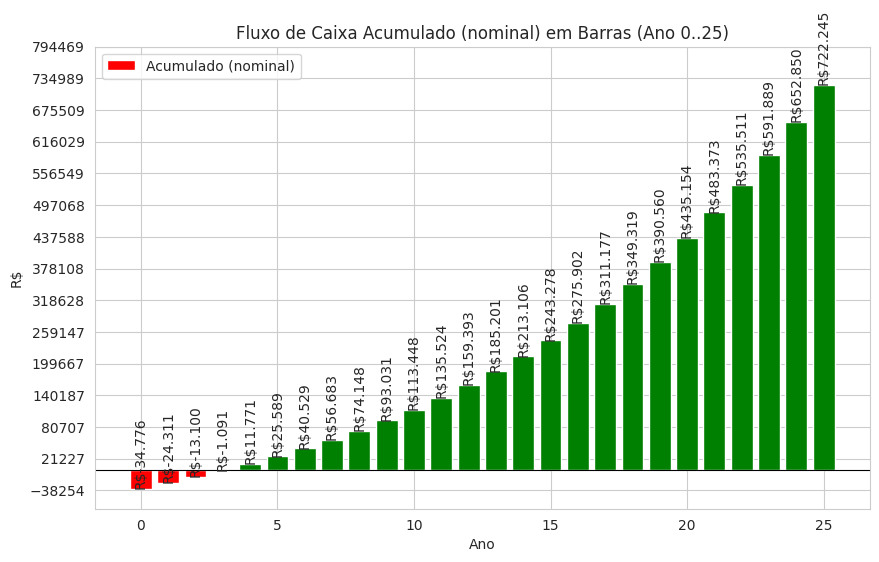

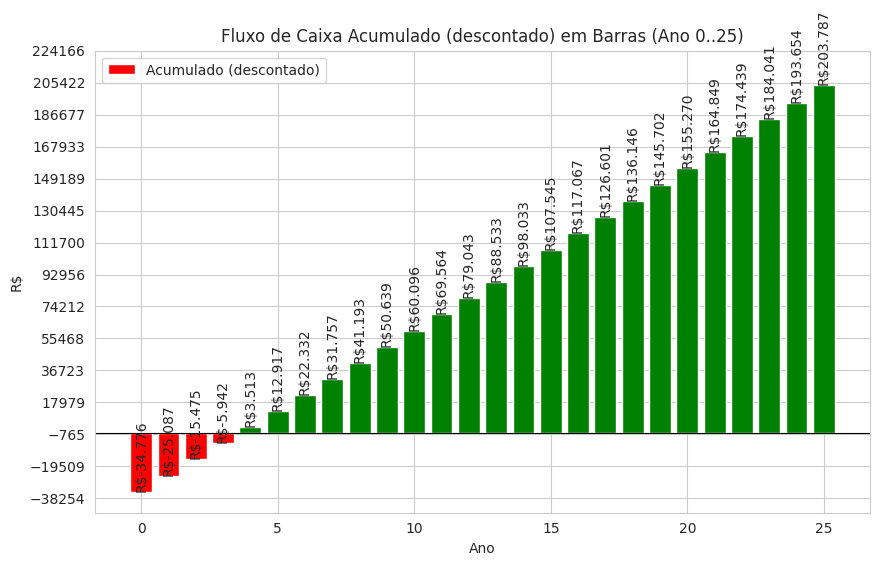

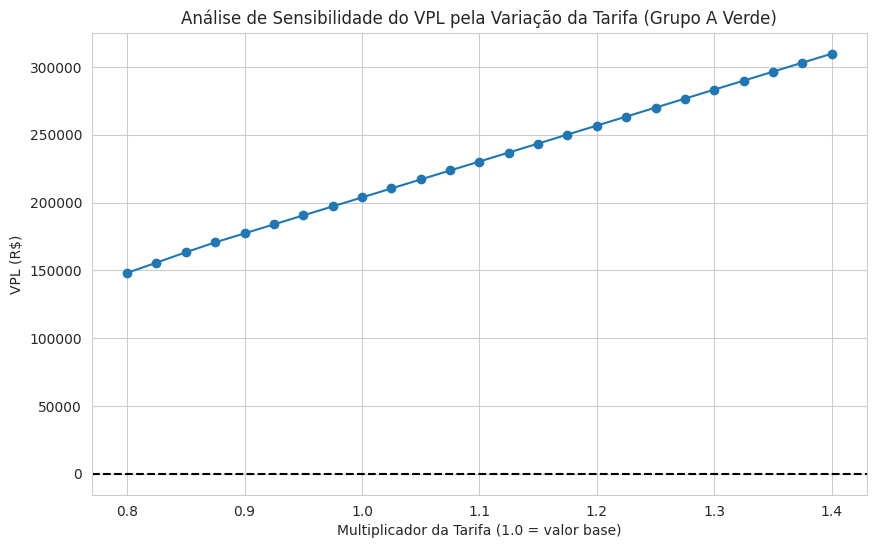



--------------------------------------------------
COMO PREENCHER OS DADOS MENSAIS:
--------------------------------------------------
Você deve alterar os dicionários no início do código, dentro da seção 'PARÂMETROS AUTOCONSUMO REMOTO'.
Os valores devem ser preenchidos em kWh para cada mês (Jan a Dez).

Exemplo:
raw_monthly_consumption_remote_B = {
   'Jan': 250, 'Fev': 230, 'Mar': 270, 'Abr': 260,
   'Mai': 220, 'Jun': 200, 'Jul': 210, 'Ago': 240,
   'Set': 250, 'Out': 280, 'Nov': 290, 'Dez': 300
}
--------------------------------------------------


In [ ]:
# =======================================================
# Análise Financeira Solar - UNIDADE GERADORA GRUPO A VERDE
# CÓDIGO FINAL E COMPLETO (VERSÃO 13.1)
# =======================================================

!pip install -q numpy-financial openpyxl xlsxwriter seaborn

import numpy as np
import pandas as pd
import numpy_financial as npf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Configuração de visualização
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("whitegrid")

# -------------------------
# ======= PARÂMETROS GERAIS ======
# -------------------------

# Dados de entrada mensais da unidade geradora (Valores já em kWh)
raw_monthly_generation = {
  "Jan": 2100.00, "Fev": 2100.00, "Mar": 2100.00, "Abr": 2100.00,
  "Mai": 2100.00, "Jun": 2100.00, "Jul": 2100.00, "Ago": 2100.00,
  "Set": 2100.00, "Out": 2100.00, "Nov": 2100.00, "Dez": 2100.00
}
raw_monthly_consumption_offpeak = { # Consumo fora de ponta
  "Jan": 1000.00, "Fev": 1000.00, "Mar": 1000.00, "Abr": 1000.00,
  "Mai": 1000.00, "Jun": 1000.00,  "Jul": 1000.00, "Ago": 1000.00,
  "Set": 1000.00, "Out": 1000.00, "Nov": 1000.00, "Dez": 1000.00
}
raw_monthly_consumption_peak = { # Consumo ponta
  "Jan": 300.00, "Fev": 280.00, "Mar": 250.00, "Abr": 220.00,
  "Mai": 200.00, "Jun": 180.00,  "Jul": 190.00, "Ago": 210.00,
  "Set": 230.00, "Out": 260.00, "Nov": 280.00, "Dez": 300.00
}

# Tarifas / regras da unidade geradora (GRUPO A VERDE)
CONCESSIONARIA = "Copel"
TARIFA_FORA_PONTA_TOTAL = 0.48       # R$/kWh (ano base)
TARIFA_PONTA_TOTAL = 2.20           # R$/kWh (ano base)
INFLACAO_ENERGIA = 0.085             # 8,5% a.a.

# Novas tarifas TE (convertidas para R$/kWh)
TE_PONTA_VERDE = 0.55158             # R$/kWh
TE_FORA_PONTA_VERDE = 0.34334        # R$/kWh

# NOVO PARÂMETRO
FATOR_SIMULTANEIDADE_LOCAL = 0.20 # Percentual da energia gerada que é consumida instantaneamente no local

# Sistema e financeiro
DEGRADACAO = 0.005                   # 0,5% a.a.
CAPEX = 34776.00                     # R$
TAXA_DESCONTO = 0.08                 # 8% a.a.
ANOS = 25
OMA_FIRST_PCT = 0.015                # O&M: 1,5% do CAPEX no ano 1
OMA_INFLACAO = TAXA_DESCONTO                  # correção 8% a.a. para O&M após ano1
SALVAGE_PCT = 0.10                   # 10% do CAPEX no final

# -------------------------
# ===== PARÂMETROS AUTOCONSUMO REMOTO =====
# -------------------------

# Pergunta 1: Haverá autoconsumo remoto para o Grupo B? (True/False)
AUTOCONSUMO_REMOTO_B = True
# Se sim, preencha os dados abaixo (kWh/mês):
raw_monthly_consumption_remote_B = {
    "Jan": 250, "Fev": 230, "Mar": 270, "Abr": 260,
    "Mai": 220, "Jun": 200, "Jul": 210, "Ago": 240,
    "Set": 250, "Out": 280, "Nov": 290, "Dez": 300
}
# FIO B e Tarifa de Energia para o Grupo B remoto
FIO_B_VALOR_REMOTO_B = 0.2135        # R$/kWh
TARIFA_TOTAL_REMOTO_B = 0.84         # R$/kWh
FIO_B_SCHEDULE = {2025: 0.45, 2026: 0.60, 2027: 0.75, 2028: 0.90}
BASE_YEAR = 2025

# ---
# Pergunta 2: Haverá autoconsumo remoto para o Grupo A VERDE? (True/False)
AUTOCONSUMO_REMOTO_A_VERDE = True
# Se sim, preencha os dados abaixo (kWh/mês):
raw_monthly_consumption_remote_A_verde_offpeak = {
    "Jan": 500, "Fev": 500, "Mar": 500, "Abr": 500,
    "Mai": 500, "Jun": 500, "Jul": 500, "Ago": 500,
    "Set": 500, "Out": 500, "Nov": 500, "Dez": 500
}
raw_monthly_consumption_remote_A_verde_peak = {
    "Jan": 80, "Fev": 75, "Mar": 70, "Abr": 65,
    "Mai": 60, "Jun": 55, "Jul": 60, "Ago": 70,
    "Set": 75, "Out": 80, "Nov": 85, "Dez": 90
}
# Novas tarifas TE (convertidas para R$/kWh)
TE_PONTA_A_VERDE = 0.55158
TE_FORA_PONTA_A_VERDE = 0.34334
# Tarifas totais (TE + TUSD) para cálculo da economia:
TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA = 0.48
TARIFA_TOTAL_REMOTO_A_VERDE_PONTA = 2.20

# ---
# Pergunta 3: Haverá autoconsumo remoto para o Grupo A AZUL? (True/False)
AUTOCONSUMO_REMOTO_A_AZUL = True
# Se sim, preencha os dados abaixo (kWh/mês):
raw_monthly_consumption_remote_A_azul_offpeak = {
    "Jan": 3500, "Fev": 3200, "Mar": 3400, "Abr": 3100,
    "Mai": 3000, "Jun": 2800, "Jul": 3000, "Ago": 3300,
    "Set": 3400, "Out": 3600, "Nov": 3500, "Dez": 3800
}
raw_monthly_consumption_remote_A_azul_peak = {
    "Jan": 1200, "Fev": 1100, "Mar": 1000, "Abr": 950,
    "Mai": 900, "Jun": 850, "Jul": 900, "Ago": 1050,
    "Set": 1100, "Out": 1200, "Nov": 1250, "Dez": 1300
}
# Novas tarifas TE (convertidas para R$/kWh)
TE_PONTA_A_AZUL = 0.55158
TE_FORA_PONTA_A_AZUL = 0.34334
# Tarifas totais (TE + TUSD) para cálculo da economia:
TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA = 0.48
TARIFA_TOTAL_REMOTO_A_AZUL_PONTA = 2.20

# ---
# Pergunta 4: Percentuais de Créditos
PERC_ABATIMENTO_B = 0.20      # 40% dos créditos da sobra para o Grupo B
PERC_ABATIMENTO_A_VERDE = 0.40  # 30% dos créditos da sobra para o Grupo A VERDE
PERC_ABATIMENTO_A_AZUL = 0.40  # 30% dos créditos da sobra para o Grupo A AZUL


# -------------------------
# ======= PREPARAÇÃO (NÃO ALTERAR) ======
# -------------------------
months = list(raw_monthly_generation.keys())
gen_monthly = np.array([raw_monthly_generation[m] for m in months], dtype=float)
cons_monthly_fp = np.array([raw_monthly_consumption_offpeak[m] for m in months], dtype=float)
cons_monthly_p = np.array([raw_monthly_consumption_peak[m] for m in months], dtype=float)

# Consumo total mensal de cada unidade remota
cons_monthly_remoto_b = np.array([raw_monthly_consumption_remote_B[m] for m in months], dtype=float) if AUTOCONSUMO_REMOTO_B else np.zeros(12)
cons_monthly_remoto_a_verde_fp = np.array([raw_monthly_consumption_remote_A_verde_offpeak[m] for m in months], dtype=float) if AUTOCONSUMO_REMOTO_A_VERDE else np.zeros(12)
cons_monthly_remoto_a_verde_p = np.array([raw_monthly_consumption_remote_A_verde_peak[m] for m in months], dtype=float) if AUTOCONSUMO_REMOTO_A_VERDE else np.zeros(12)
cons_monthly_remoto_a_azul_fp = np.array([raw_monthly_consumption_remote_A_azul_offpeak[m] for m in months], dtype=float) if AUTOCONSUMO_REMOTO_A_AZUL else np.zeros(12)
cons_monthly_remoto_a_azul_p = np.array([raw_monthly_consumption_remote_A_azul_peak[m] for m in months], dtype=float) if AUTOCONSUMO_REMOTO_A_AZUL else np.zeros(12)

GERACAO_ANUAL_CALCULADA = gen_monthly.sum()
CONSUMO_ANUAL_FORA_PONTA_CALCULADO = cons_monthly_fp.sum()
CONSUMO_ANUAL_PONTA_CALCULADO = cons_monthly_p.sum()
CONSUMO_ANUAL_REMOTO_B_CALCULADO = cons_monthly_remoto_b.sum()
CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO = cons_monthly_remoto_a_verde_fp.sum()
CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO = cons_monthly_remoto_a_verde_p.sum()
CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO = cons_monthly_remoto_a_azul_fp.sum()
CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO = cons_monthly_remoto_a_azul_p.sum()

print("Somas anuais de consumo e geração (usando os dados mensais informados):")
print(f" - Geração anual (ano1, soma meses): {GERACAO_ANUAL_CALCULADA:,.2f} kWh".replace(",", "."))
print(f" - Consumo local fora de ponta: {CONSUMO_ANUAL_FORA_PONTA_CALCULADO:,.2f} kWh".replace(",", "."))
print(f" - Consumo local ponta: {CONSUMO_ANUAL_PONTA_CALCULADO:,.2f} kWh".replace(",", "."))
if AUTOCONSUMO_REMOTO_B:
    print(f" - Consumo remoto Grupo B: {CONSUMO_ANUAL_REMOTO_B_CALCULADO:,.2f} kWh".replace(",", "."))
if AUTOCONSUMO_REMOTO_A_VERDE:
    print(f" - Consumo remoto Grupo A Verde FP: {CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f" - Consumo remoto Grupo A Verde Ponta: {CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO:,.2f} kWh".replace(",", "."))
if AUTOCONSUMO_REMOTO_A_AZUL:
    print(f" - Consumo remoto Grupo A Azul FP: {CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f" - Consumo remoto Grupo A Azul Ponta: {CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO:,.2f} kWh".replace(",", "."))
print(f" - CAPEX: R$ {CAPEX:,.2f}\n".replace(",", "."))


# ======= Novas tarifas TUSD e fatores de ajuste (calculados internamente) ======
TUSD_REMOTO_A_VERDE_FORA_PONTA = TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA - TE_FORA_PONTA_A_VERDE
TUSD_REMOTO_A_VERDE_PONTA = TARIFA_TOTAL_REMOTO_A_VERDE_PONTA - TE_PONTA_A_VERDE
TUSD_REMOTO_A_AZUL_FORA_PONTA = TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA - TE_FORA_PONTA_A_AZUL
TUSD_REMOTO_A_AZUL_PONTA = TARIFA_TOTAL_REMOTO_A_AZUL_PONTA - TE_PONTA_A_AZUL
FATOR_AJUSTE_GERADORA = TE_PONTA_VERDE / TE_FORA_PONTA_VERDE
FATOR_AJUSTE_REMOTO_A_VERDE = TE_PONTA_A_VERDE / TE_FORA_PONTA_A_VERDE
FATOR_AJUSTE_REMOTO_A_AZUL = TE_PONTA_A_AZUL / TE_FORA_PONTA_A_AZUL


# -------------------------
# ======= CÁLCULOS PRINCIPAIS ======
# -------------------------
anos = np.arange(1, ANOS + 1)

# Variáveis para a nova tabela de resumo
gen_annual = np.zeros_like(anos, dtype=float)
economia_geradora_annual = np.zeros_like(anos, dtype=float)
custo_demanda_geradora_annual = np.zeros_like(anos, dtype=float)
consumo_geradora_fp_annual = np.zeros_like(anos, dtype=float)
consumo_geradora_p_annual = np.zeros_like(anos, dtype=float)
abatido_geradora_fp_annual = np.zeros_like(anos, dtype=float)
abatido_geradora_p_annual = np.zeros_like(anos, dtype=float)
creditos_usados_ponta_annual = np.zeros_like(anos, dtype=float)
abatido_remoto_b_annual = np.zeros_like(anos, dtype=float)
abatido_remoto_a_verde_ponta_annual = np.zeros_like(anos, dtype=float)
abatido_remoto_a_verde_foraponta_annual = np.zeros_like(anos, dtype=float)
abatido_remoto_a_azul_ponta_annual = np.zeros_like(anos, dtype=float)
abatido_remoto_a_azul_foraponta_annual = np.zeros_like(anos, dtype=float)
creditos_usados_remoto_a_verde_ponta_annual = np.zeros_like(anos, dtype=float)
creditos_usados_remoto_a_azul_ponta_annual = np.zeros_like(anos, dtype=float)
economia_remoto_b_annual = np.zeros_like(anos, dtype=float)
economia_remoto_a_verde_ponta_annual = np.zeros_like(anos, dtype=float)
economia_remoto_a_verde_foraponta_annual = np.zeros_like(anos, dtype=float)
economia_remoto_a_azul_ponta_annual = np.zeros_like(anos, dtype=float)
economia_remoto_a_azul_foraponta_annual = np.zeros_like(anos, dtype=float)
economia_total_annual = np.zeros_like(anos, dtype=float)
oma_annual = np.zeros_like(anos, dtype=float)
net_cash_annual = np.zeros_like(anos, dtype=float)
economia_simultanea_annual = np.zeros_like(anos, dtype=float)
energia_simultanea_annual = np.zeros_like(anos, dtype=float)
# Nova variável para exibir o valor correto
abatido_fp_local_por_credito_annual_for_display = np.zeros_like(anos, dtype=float)

# Bancos de créditos mensais
bank_b = 0
bank_a_verde = 0
bank_a_azul = 0

for idx, ano in enumerate(anos, start=1):

    # Resetting annual variables for each year
    econ_geradora_acum = 0
    abatido_fp_geradora_acum = 0
    abatido_p_geradora_acum = 0
    creditos_usados_p_geradora_acum = 0
    econ_remoto_b_acum = 0
    abatido_remoto_b_acum = 0
    econ_remoto_a_verde_fp_acum = 0
    econ_remoto_a_verde_p_acum = 0
    abatido_remoto_a_verde_fp_acum = 0
    abatido_remoto_a_verde_p_acum = 0
    creditos_usados_remoto_a_verde_p_acum = 0
    econ_remoto_a_azul_fp_acum = 0
    econ_remoto_a_azul_p_acum = 0
    abatido_remoto_a_azul_fp_acum = 0
    abatido_remoto_a_azul_p_acum = 0
    creditos_usados_remoto_a_azul_p_acum = 0
    economia_simultanea_acum = 0
    energia_simultanea_acum = 0
    abatido_fp_local_por_credito_acum = 0 # NOVO: Para separar o que foi abatido por crédito vs. o que foi por autoconsumo

    # Tarifas do ano (Total = TE + TUSD)
    tarifa_fp_y = TARIFA_FORA_PONTA_TOTAL * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
    tarifa_p_y = TARIFA_PONTA_TOTAL * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
    tarifa_demanda_y = TARIFA_DEMANDA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))

    # Custo Demanda
    custo_demanda_geradora_annual[idx-1] = DEMANDA_CONTRATADA * tarifa_demanda_y * 12

    for month_idx in range(12):
        # CÁLCULOS DA UNIDADE GERADORA LOCAL (GRUPO A VERDE)
        factor_deg = (1 - DEGRADACAO) ** (ano - 1)
        gen_month = gen_monthly[month_idx] * factor_deg
        cons_fp_geradora_month = cons_monthly_fp[month_idx]
        cons_p_geradora_month = cons_monthly_p[month_idx]

        # === LÓGICA ATUALIZADA: Autoconsumo Imediato abate o consumo FORA PONTA local ===
        energia_autoconsumo_imediato = gen_month * FATOR_SIMULTANEIDADE_LOCAL
        # A economia desse autoconsumo é o valor total da energia evitada
        economia_autoconsumo_imediato = energia_autoconsumo_imediato * tarifa_fp_y

        # O consumo fora de ponta é o total menos o autoconsumo imediato
        consumo_fp_pos_autoconsumo = max(0, cons_fp_geradora_month - energia_autoconsumo_imediato)
        # O que sobrou da geração vira crédito para abatimento (dentro e fora da unidade geradora)
        creditos_iniciais_local = gen_month - energia_autoconsumo_imediato

        # Logica de abatimento: PRIORIDADE FORA DE PONTA com os créditos restantes
        abatido_fp_local_por_credito = min(creditos_iniciais_local, consumo_fp_pos_autoconsumo)
        sobra_geracao_fp = creditos_iniciais_local - abatido_fp_local_por_credito

        # Abate o consumo de ponta com o fator de ajuste
        abatido_p_local_real = min(sobra_geracao_fp / FATOR_AJUSTE_GERADORA, cons_p_geradora_month)
        creditos_usados_local_ponta = abatido_p_local_real * FATOR_AJUSTE_GERADORA

        # Acumula os valores anuais
        abatido_fp_geradora_acum += abatido_fp_local_por_credito
        abatido_p_geradora_acum += abatido_p_local_real
        creditos_usados_p_geradora_acum += creditos_usados_local_ponta
        abatido_fp_local_por_credito_acum += abatido_fp_local_por_credito

        # Créditos para unidades remotas (o que sobrou de fato)
        creditos_disponiveis_month = sobra_geracao_fp - creditos_usados_local_ponta

        # === Economia na Unidade Geradora Local ===
        economia_fp_geradora = abatido_fp_local_por_credito * (tarifa_fp_y - (TUSD_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))))
        economia_p_geradora = abatido_p_local_real * (tarifa_p_y - (TUSD_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))))
        econ_geradora_acum += (economia_fp_geradora + economia_p_geradora)
        economia_simultanea_acum += economia_autoconsumo_imediato
        energia_simultanea_acum += energia_autoconsumo_imediato

        # ---
        # CÁLCULOS DO AUTOCONSUMO REMOTO
        tarifa_credito_geradora_y = TE_FORA_PONTA_VERDE * ((1 + INFLACAO_ENERGIA) ** (ano - 1))

        # === LÓGICA DE DISTRIBUIÇÃO DE CRÉDITOS E GESTÃO DO BANCO MENSAL ===

        # Passo 1: Alocação mensal para cada unidade
        creditos_para_b_month = creditos_disponiveis_month * PERC_ABATIMENTO_B
        creditos_para_a_verde_month = creditos_disponiveis_month * PERC_ABATIMENTO_A_VERDE
        creditos_para_a_azul_month = creditos_disponiveis_month * PERC_ABATIMENTO_A_AZUL

        # Passo 2: Abatimento e gestão do banco de créditos para o Grupo B
        if AUTOCONSUMO_REMOTO_B:
            total_credits_b = creditos_para_b_month + bank_b
            tarifa_total_remoto_b_y = TARIFA_TOTAL_REMOTO_B * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            fio_b_y = FIO_B_VALOR_REMOTO_B * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            fator_equiv_a_b = tarifa_credito_geradora_y / tarifa_total_remoto_b_y

            creditos_b_utilizados_eq = min(total_credits_b / fator_equiv_a_b, cons_monthly_remoto_b[month_idx])

            # Abatido é o valor real em kWh, não o equivalente
            abatido_remoto_b = creditos_b_utilizados_eq
            sobra_b_month = total_credits_b - (abatido_remoto_b * fator_equiv_a_b)
            bank_b = sobra_b_month # Saldo do banco

            calendar_year = BASE_YEAR + (ano - 1)
            noncomp_b = FIO_B_SCHEDULE.get(calendar_year, 1.0)
            economia_remoto_b = (abatido_remoto_b * tarifa_total_remoto_b_y) - (abatido_remoto_b * fio_b_y * noncomp_b)

            econ_remoto_b_acum += economia_remoto_b
            abatido_remoto_b_acum += abatido_remoto_b

        # Passo 3: Abatimento e gestão do banco de créditos para o Grupo A VERDE
        if AUTOCONSUMO_REMOTO_A_VERDE:
            total_credits_a_verde = creditos_para_a_verde_month + bank_a_verde

            # Prioridade FORA DE PONTA
            abatido_fp_a_verde = min(total_credits_a_verde, cons_monthly_remoto_a_verde_fp[month_idx])
            sobra_a_verde_fp = total_credits_a_verde - abatido_fp_a_verde

            # Abate na ponta com o que sobrou
            abatido_p_a_verde = min(sobra_a_verde_fp / FATOR_AJUSTE_REMOTO_A_VERDE, cons_monthly_remoto_a_verde_p[month_idx])
            creditos_usados_remoto_a_verde_p = abatido_p_a_verde * FATOR_AJUSTE_REMOTO_A_VERDE

            sobra_a_verde_total = sobra_a_verde_fp - creditos_usados_remoto_a_verde_p
            bank_a_verde = sobra_a_verde_total

            tarifa_total_remoto_a_verde_fp_y = TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            tarifa_total_remoto_a_verde_p_y = TARIFA_TOTAL_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            tusc_remoto_a_verde_fp_y = TUSD_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            tusc_remoto_a_verde_p_y = TUSD_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))

            economia_remoto_a_verde_p = abatido_p_a_verde * tarifa_total_remoto_a_verde_p_y - (abatido_p_a_verde * tusc_remoto_a_verde_p_y)
            economia_remoto_a_verde_fp = abatido_fp_a_verde * tarifa_total_remoto_a_verde_fp_y - (abatido_fp_a_verde * tusc_remoto_a_verde_fp_y)

            econ_remoto_a_verde_fp_acum += economia_remoto_a_verde_fp
            econ_remoto_a_verde_p_acum += economia_remoto_a_verde_p
            abatido_remoto_a_verde_fp_acum += abatido_fp_a_verde
            abatido_remoto_a_verde_p_acum += abatido_p_a_verde
            creditos_usados_remoto_a_verde_p_acum += creditos_usados_remoto_a_verde_p

        # Passo 4: Abatimento e gestão do banco de créditos para o Grupo A AZUL
        if AUTOCONSUMO_REMOTO_A_AZUL:
            total_credits_a_azul = creditos_para_a_azul_month + bank_a_azul

            # Prioridade FORA DE PONTA
            abatido_fp_a_azul = min(total_credits_a_azul, cons_monthly_remoto_a_azul_fp[month_idx])
            sobra_a_azul_fp = total_credits_a_azul - abatido_fp_a_azul

            # Abate na ponta com o que sobrou
            abatido_p_a_azul = min(sobra_a_azul_fp / FATOR_AJUSTE_REMOTO_A_AZUL, cons_monthly_remoto_a_azul_p[month_idx])
            creditos_usados_remoto_a_azul_p = abatido_p_a_azul * FATOR_AJUSTE_REMOTO_A_AZUL

            sobra_a_azul_total = sobra_a_azul_fp - creditos_usados_remoto_a_azul_p
            bank_a_azul = sobra_a_azul_total

            tarifa_total_remoto_a_azul_fp_y = TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            tarifa_total_remoto_a_azul_p_y = TARIFA_TOTAL_REMOTO_A_AZUL_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            tusc_remoto_a_azul_fp_y = TUSD_REMOTO_A_AZUL_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))
            tusc_remoto_a_azul_p_y = TUSD_REMOTO_A_AZUL_PONTA * ((1 + INFLACAO_ENERGIA) ** (ano - 1))

            economia_remoto_a_azul_p = abatido_p_a_azul * tarifa_total_remoto_a_azul_p_y - (abatido_p_a_azul * tusc_remoto_a_azul_p_y)
            economia_remoto_a_azul_fp = abatido_fp_a_azul * tarifa_total_remoto_a_azul_fp_y - (abatido_fp_a_azul * tusc_remoto_a_azul_fp_y)

            econ_remoto_a_azul_fp_acum += economia_remoto_a_azul_fp
            econ_remoto_a_azul_p_acum += economia_remoto_a_azul_p
            abatido_remoto_a_azul_fp_acum += abatido_fp_a_azul
            abatido_remoto_a_azul_p_acum += abatido_p_a_azul
            creditos_usados_remoto_a_azul_p_acum += creditos_usados_remoto_a_azul_p

    # Preenche os dados anuais para o resumo final
    gen_annual[idx-1] = gen_monthly.sum() * factor_deg
    consumo_geradora_fp_annual[idx-1] = cons_monthly_fp.sum()
    consumo_geradora_p_annual[idx-1] = cons_monthly_p.sum()
    abatido_geradora_fp_annual[idx-1] = abatido_fp_geradora_acum + energia_simultanea_acum # Consumo imediato + créditos
    abatido_fp_local_por_credito_annual_for_display[idx-1] = abatido_fp_local_por_credito_acum # Adiciona a nova variável
    abatido_geradora_p_annual[idx-1] = abatido_p_geradora_acum
    creditos_usados_ponta_annual[idx-1] = creditos_usados_p_geradora_acum
    economia_geradora_annual[idx-1] = econ_geradora_acum
    economia_simultanea_annual[idx-1] = economia_simultanea_acum
    energia_simultanea_annual[idx-1] = energia_simultanea_acum

    abatido_remoto_b_annual[idx-1] = abatido_remoto_b_acum
    economia_remoto_b_annual[idx-1] = econ_remoto_b_acum

    abatido_remoto_a_verde_foraponta_annual[idx-1] = abatido_remoto_a_verde_fp_acum
    abatido_remoto_a_verde_ponta_annual[idx-1] = abatido_remoto_a_verde_p_acum
    economia_remoto_a_verde_foraponta_annual[idx-1] = econ_remoto_a_verde_fp_acum
    economia_remoto_a_verde_ponta_annual[idx-1] = econ_remoto_a_verde_p_acum
    creditos_usados_remoto_a_verde_ponta_annual[idx-1] = creditos_usados_remoto_a_verde_p_acum

    abatido_remoto_a_azul_foraponta_annual[idx-1] = abatido_remoto_a_azul_fp_acum
    abatido_remoto_a_azul_ponta_annual[idx-1] = abatido_remoto_a_azul_p_acum
    economia_remoto_a_azul_foraponta_annual[idx-1] = econ_remoto_a_azul_fp_acum
    economia_remoto_a_azul_ponta_annual[idx-1] = econ_remoto_a_azul_p_acum
    creditos_usados_remoto_a_azul_ponta_annual[idx-1] = creditos_usados_remoto_a_azul_p_acum

    economia_total_annual[idx-1] = economia_simultanea_annual[idx-1] + economia_geradora_annual[idx-1] + economia_remoto_b_annual[idx-1] + economia_remoto_a_verde_ponta_annual[idx-1] + economia_remoto_a_verde_foraponta_annual[idx-1] + economia_remoto_a_azul_ponta_annual[idx-1] + economia_remoto_a_azul_foraponta_annual[idx-1]

    oma = CAPEX * OMA_FIRST_PCT * ((1 + OMA_INFLACAO) ** (ano - 1))
    oma_annual[idx-1] = oma

    # === FLUXO DE CAIXA CORRIGIDO (SEM CUSTO DE DEMANDA) ===
    fluxo = economia_total_annual[idx-1] - oma
    if ano == ANOS:
        fluxo += CAPEX * SALVAGE_PCT
    net_cash_annual[idx-1] = fluxo

flows = np.concatenate(([-CAPEX], net_cash_annual))
ts = np.arange(0, ANOS + 1)
discount_factors = 1.0 / ((1 + TAXA_DESCONTO) ** ts)
VPL = (flows * discount_factors).sum()
try:
    TIR = npf.irr(flows)
except Exception:
    TIR = None
pv_flows = (flows * discount_factors)
pv_inflows = pv_flows[pv_flows > 0].sum()
pv_outflows = -pv_flows[pv_flows < 0].sum()
PI = pv_inflows / pv_outflows if pv_outflows != 0 else None
ECONOMIA_TOTAL_NOMINAL = economia_total_annual.sum()
LCOE = VPL / (gen_annual * discount_factors[1:]).sum() if (gen_annual * discount_factors[1:]).sum() > 0 else None
ROI_SIMPLE = (ECONOMIA_TOTAL_NOMINAL - CAPEX) / CAPEX * 100.0
cumul_nominal = np.cumsum(flows)
payback_simple = None
payback_simple_frac = None
for t in range(1, len(cumul_nominal)):
    if cumul_nominal[t] >= 0:
        prev = cumul_nominal[t-1]
        curr = cumul_nominal[t]
        if curr == prev:
            payback_simple_frac = float(t)
        else:
            frac = -prev / (curr - prev)
            payback_simple_frac = (t-1) + frac
        payback_simple = payback_simple_frac
        break
disc_flows = flows * discount_factors
cumul_discounted = np.cumsum(disc_flows)
payback_disc = None
payback_disc_frac = None
for t in range(1, len(cumul_discounted)):
    if cumul_discounted[t] >= 0:
        prev = cumul_discounted[t-1]
        curr = cumul_discounted[t]
        if curr == prev:
            payback_disc_frac = float(t)
        else:
            frac = -prev / (curr - prev)
            payback_disc_frac = (t-1) + frac
        payback_disc = payback_disc_frac
        break
CUSTO_EVITADO_NOMINAL = economia_total_annual.sum()
CUSTO_EVITADO_PV = (economia_total_annual * discount_factors[1:]).sum()

# Criando o DataFrame para a tabela de resultados
data = {
    'Ano': anos,
    'Geração (kWh)': gen_annual,
    'Consumo Geradora FP (kWh)': consumo_geradora_fp_annual,
    'Consumo Geradora P (kWh)': consumo_geradora_p_annual,
    'Abatido Geradora FP (kWh)': abatido_geradora_fp_annual,
    'Abatido Geradora P (kWh)': abatido_geradora_p_annual,
    'Energia Simultanea (kWh)': energia_simultanea_annual,
    'Economia Local (R$)': economia_geradora_annual,
    'Economia Simultanea (R$)': economia_simultanea_annual,
    'Custo Demanda (R$)': custo_demanda_geradora_annual,
    'Abatido Remoto B (kWh)': abatido_remoto_b_annual,
    'Economia Remoto B (R$)': economia_remoto_b_annual,
    'Abatido Remoto A Verde FP (kWh)': abatido_remoto_a_verde_foraponta_annual,
    'Abatido Remoto A Verde P (kWh)': abatido_remoto_a_verde_ponta_annual,
    'Economia Remoto A Verde FP (R$)': economia_remoto_a_verde_foraponta_annual,
    'Economia Remoto A Verde P (R$)': economia_remoto_a_verde_ponta_annual,
    'Abatido Remoto A Azul FP (kWh)': abatido_remoto_a_azul_foraponta_annual,
    'Abatido Remoto A Azul P (kWh)': abatido_remoto_a_azul_ponta_annual,
    'Economia Remoto A Azul FP (R$)': economia_remoto_a_azul_foraponta_annual,
    'Economia Remoto A Azul P (R$)': economia_remoto_a_azul_ponta_annual,
    'O&M (R$)': oma_annual,
    'Economia Total (R$)': economia_total_annual,
    'Fluxo de Caixa (R$)': net_cash_annual
}
df = pd.DataFrame(data)
df.set_index('Ano', inplace=True)
for col in df.columns:
    if 'kWh' in col:
        df[col] = df[col].astype(int)
    if 'R$' in col:
        df[col] = df[col].round(2)

# Criando o resumo financeiro
resumo = {
    "Valor Presente Líquido (VPL)": f"R$ {VPL:,.2f}".replace(",", "."),
    "Taxa Interna de Retorno (TIR)": f"{TIR:.2%}" if TIR is not None else "N/A",
    "Índice de Lucratividade (PI)": f"{PI:,.2f}".replace(",", ".") if PI is not None else "N/A",
    "Payback Simples": f"{payback_simple:.2f} anos" if payback_simple is not None else "N/A",
    "Payback Descontado": f"{payback_disc:.2f} anos" if payback_disc is not None else "N/A",
    "Custo de Energia (LCOE)": f"R$ {LCOE:,.2f}/kWh".replace(",", ".") if LCOE is not None else "N/A",
    "Retorno sobre Investimento (ROI) Simples": f"{ROI_SIMPLE:,.2f}%".replace(",", "."),
    "Economia Total Projetada (Nominal)": f"R$ {CUSTO_EVITADO_NOMINAL:,.2f}".replace(",", "."),
    "Economia Total Projetada (Valor Presente)": f"R$ {CUSTO_EVITADO_PV:,.2f}".replace(",", "."),
}

# -------------------------
# ======== RESULTADOS ========
# -------------------------

# Impressão resumo financeiro
print("\n==== RESUMO FINANCEIRO COMPLETO (LOCAL + REMOTO) ====")
for k,v in resumo.items():
    print(f" - {k}: {v}")

# Resumo de Geração e Consumo (Ano 1)
print("\n==== RESUMO DE GERAÇÃO E CONSUMO (ANO 1) ====")

# Geração
print("\n[ Geração ]")
print(f"Geração Anual: {gen_annual[0]:,.2f} kWh".replace(",", "."))
print(f"Energia Consumida no Local (Simultânea - 30%): {energia_simultanea_annual[0]:,.2f} kWh".replace(",", "."))
print(f"Energia Excedente para Créditos: {gen_annual[0] - energia_simultanea_annual[0]:,.2f} kWh".replace(",", "."))

# Consumo Local - Lógica de impressão alterada aqui
print("\n[ Unidade Geradora Local (Grupo A Verde) ]")
print(f"Consumo Total Local: {CONSUMO_ANUAL_FORA_PONTA_CALCULADO + CONSUMO_ANUAL_PONTA_CALCULADO:,.2f} kWh".replace(",", "."))
print(f"Consumo Fora Ponta: {consumo_geradora_fp_annual[0]:,.2f} kWh".replace(",", "."))
print(f"   -> Abatido por Autoconsumo Imediato: {energia_simultanea_annual[0]:,.2f} kWh".replace(",", "."))
saldo_fp = max(0, consumo_geradora_fp_annual[0] - energia_simultanea_annual[0])
print(f"   -> Saldo a Abater Fora Ponta (por créditos): {saldo_fp:,.2f} kWh".replace(",", "."))
print(f"   -> Abatido com Créditos (Fora Ponta): {abatido_fp_local_por_credito_annual_for_display[0]:,.2f} kWh".replace(",", "."))
print(f"Percentual Abatido Fora Ponta: {(abatido_geradora_fp_annual[0] / consumo_geradora_fp_annual[0]) * 100:,.2f}%".replace(",", "."))
print(f"Consumo Ponta: {consumo_geradora_p_annual[0]:,.2f} kWh".replace(",", "."))
print(f"   -> Abatido Ponta: {abatido_geradora_p_annual[0]:,.2f} kWh".replace(",", "."))
print(f"Percentual Abatido Ponta: {(abatido_geradora_p_annual[0] / consumo_geradora_p_annual[0]) * 100:,.2f}%".replace(",", "."))
print(f"Créditos Usados para Abater Ponta: {creditos_usados_ponta_annual[0]:,.2f} kWh".replace(",", "."))
print(f"Economia gerada por Autoconsumo Imediato: R$ {economia_simultanea_annual[0]:,.2f}".replace(",", "."))


# Grupo B remoto
if AUTOCONSUMO_REMOTO_B:
    print("\n[ Grupo B Remoto ]")
    perc_abatido_b = (abatido_remoto_b_annual[0] / CONSUMO_ANUAL_REMOTO_B_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_B_CALCULADO > 0 else 0
    print(f"Consumo Remoto B: {CONSUMO_ANUAL_REMOTO_B_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Grupo B: {abatido_remoto_b_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Percentual Abatido Grupo B: {perc_abatido_b:,.2f}%".replace(",", "."))

# Grupo A verde remoto
if AUTOCONSUMO_REMOTO_A_VERDE:
    print("\n[ Grupo A Verde Remoto ]")
    perc_abatido_fp_verde = (abatido_remoto_a_verde_foraponta_annual[0] / CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO > 0 else 0
    perc_abatido_p_verde = (abatido_remoto_a_verde_ponta_annual[0] / CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO > 0 else 0
    print(f"Prioridade de Abatimento: FORA_PONTA (padrão do sistema)")
    print(f"Consumo Remoto Fora Ponta: {CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f"Consumo Remoto Ponta: {CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Fora Ponta: {abatido_remoto_a_verde_foraponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Ponta: {abatido_remoto_a_verde_ponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Percentual Abatido Fora Ponta: {perc_abatido_fp_verde:,.2f}%".replace(",", "."))
    print(f"Percentual Abatido Ponta: {perc_abatido_p_verde:,.2f}%".replace(",", "."))

# Grupo A azul remoto
if AUTOCONSUMO_REMOTO_A_AZUL:
    print("\n[ Grupo A Azul Remoto ]")
    perc_abatido_fp_azul = (abatido_remoto_a_azul_foraponta_annual[0] / CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO > 0 else 0
    perc_abatido_p_azul = (abatido_remoto_a_azul_ponta_annual[0] / CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO > 0 else 0
    print(f"Prioridade de Abatimento: FORA_PONTA (padrão do sistema)")
    print(f"Consumo Remoto Fora Ponta: {CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f"Consumo Remoto Ponta: {CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Fora Ponta: {abatido_remoto_a_azul_foraponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Consumo Abatido Ponta: {abatido_remoto_a_azul_ponta_annual[0]:,.2f} kWh".replace(",", "."))
    print(f"Percentual Abatido Fora Ponta: {perc_abatido_fp_azul:,.2f}%".replace(",", "."))
    print(f"Percentual Abatido Ponta: {perc_abatido_p_azul:,.2f}%".replace(",", "."))

# ---
# NOVO: Tabela de Resumo de Economia e Tarifas por ano
# ---

# Criando as colunas de percentual de abatimento
perc_abatido_fp_local_annual = (abatido_geradora_fp_annual / CONSUMO_ANUAL_FORA_PONTA_CALCULADO) * 100 if CONSUMO_ANUAL_FORA_PONTA_CALCULADO > 0 else np.zeros_like(anos)
perc_abatido_p_local_annual = (abatido_geradora_p_annual / CONSUMO_ANUAL_PONTA_CALCULADO) * 100 if CONSUMO_ANUAL_PONTA_CALCULADO > 0 else np.zeros_like(anos)
perc_abatido_remoto_b_annual = (abatido_remoto_b_annual / CONSUMO_ANUAL_REMOTO_B_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_B_CALCULADO > 0 else np.zeros_like(anos)
perc_abatido_remoto_a_verde_fp_annual = (abatido_remoto_a_verde_foraponta_annual / CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_VERDE_FP_CALCULADO > 0 else np.zeros_like(anos)
perc_abatido_remoto_a_verde_p_annual = (abatido_remoto_a_verde_ponta_annual / CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_VERDE_P_CALCULADO > 0 else np.zeros_like(anos)
perc_abatido_remoto_a_azul_fp_annual = (abatido_remoto_a_azul_foraponta_annual / CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_AZUL_FP_CALCULADO > 0 else np.zeros_like(anos)
perc_abatido_remoto_a_azul_p_annual = (abatido_remoto_a_azul_ponta_annual / CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO) * 100 if CONSUMO_ANUAL_REMOTO_A_AZUL_P_CALCULADO > 0 else np.zeros_like(anos)

# Criando a nova tabela de resumo de economia simplificada
data_resumo_economia_simplificada = {
    'Ano': anos,
    'Geração (kWh)': gen_annual,
    'Econ. Simultanea (R$)': economia_simultanea_annual,
    'Percentual Abatido Local FP (%)': perc_abatido_fp_local_annual,
    'Econ. Local FP (R$)': (abatido_geradora_fp_annual * TARIFA_FORA_PONTA_TOTAL * ((1+INFLACAO_ENERGIA)**(anos-1))) - (abatido_geradora_fp_annual * (TUSD_REMOTO_A_VERDE_FORA_PONTA * ((1 + INFLACAO_ENERGIA) ** (anos - 1)))),
    'Percentual Abatido Local P (%)': perc_abatido_p_local_annual,
    'Econ. Local P (R$)': (abatido_geradora_p_annual * TARIFA_PONTA_TOTAL * ((1+INFLACAO_ENERGIA)**(anos-1))) - (abatido_geradora_p_annual * (TUSD_REMOTO_A_VERDE_PONTA * ((1 + INFLACAO_ENERGIA) ** (anos - 1)))),
    'Créditos Usados P (kWh)': creditos_usados_ponta_annual,
    'Custo Demanda (R$)': custo_demanda_geradora_annual,
    'Percentual Abatido Remoto B (%)': perc_abatido_remoto_b_annual,
    'Econ. Remoto B (R$)': economia_remoto_b_annual,
    'Econ. Remoto A Verde FP (R$)': economia_remoto_a_verde_foraponta_annual,
    'Econ. Remoto A Verde P (R$)': economia_remoto_a_verde_ponta_annual,
    'Econ. Remoto A Azul FP (R$)': economia_remoto_a_azul_foraponta_annual,
    'Econ. Remoto A Azul P (R$)': economia_remoto_a_azul_ponta_annual,
    'O&M (R$)': oma_annual,
    'Economia Total (R$)': economia_total_annual,
    'Fluxo de Caixa Acumulado (Descontado)': cumul_discounted[1:]
}

df_resumo_economia_simplificada = pd.DataFrame(data_resumo_economia_simplificada)
df_resumo_economia_simplificada.set_index('Ano', inplace=True)
for col in df_resumo_economia_simplificada.columns:
    if 'kWh' in col:
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].astype(int)
    elif '%' in col:
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].round(2)
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].map('{:,.2f}%'.format).str.replace('.', 'X').str.replace(',', '.').str.replace('X', ',')
    elif 'R$' in col:
        df_resumo_economia_simplificada[col] = df_resumo_economia_simplificada[col].map('R${:,.2f}'.format).str.replace('.', 'X').str.replace(',', '.').str.replace('X', ',')

print("\n==== RESUMO ANUAL SIMPLIFICADO DE ECONOMIA (25 ANOS) ====")
display(df_resumo_economia_simplificada)

# ---
# Tabela de Fluxo de Caixa (Mantida)
# ---
df_fluxos = pd.DataFrame({
    'Ano': np.arange(0, ANOS + 1),
    'Fluxo de Caixa (Nominal)': flows,
    'Fluxo de Caixa Acumulado (Nominal)': cumul_nominal,
    'Fluxo de Caixa (Descontado)': disc_flows,
    'Fluxo de Caixa Acumulado (Descontado)': cumul_discounted
})

for col in df_fluxos.columns:
    if 'R$' in col:
        df_fluxos[col] = df_fluxos[col].map('R${:,.2f}'.format).str.replace('.', 'X').str.replace(',', '.').str.replace('X', ',')
    else:
        df_fluxos[col] = df_fluxos[col].round(2)

print("\n==== Tabela de Fluxos de Caixa (Nominal e Descontado) ====")
display(df_fluxos)

# -------------------------
# GRÁFICOS
# -------------------------
anos_com_zero = np.arange(0, ANOS + 1)
cumul_nominal_com_zero = cumul_nominal
plt.figure()
cores_acumulado = ['red' if val < 0 else 'green' for val in cumul_nominal_com_zero]
plt.bar(anos_com_zero, cumul_nominal_com_zero, color=cores_acumulado, label="Acumulado (nominal)")
for i, valor in enumerate(cumul_nominal_com_zero):
    plt.text(i, valor, f'R${valor:,.0f}'.replace(',', '.'), ha='center', va='bottom', rotation=90)
plt.yticks(np.linspace(min(cumul_nominal_com_zero) * 1.1, max(cumul_nominal_com_zero) * 1.1, 15))
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Ano")
plt.ylabel("R$")
plt.title("Fluxo de Caixa Acumulado (nominal) em Barras (Ano 0..25)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
cores_acumulado_desc = ['red' if val < 0 else 'green' for val in cumul_discounted]
plt.bar(anos_com_zero, cumul_discounted, color=cores_acumulado_desc, label="Acumulado (descontado)")
for i, valor in enumerate(cumul_discounted):
    plt.text(i, valor, f'R${valor:,.0f}'.replace(',', '.'), ha='center', va='bottom', rotation=90)
plt.yticks(np.linspace(min(cumul_discounted) * 1.1, max(cumul_discounted) * 1.1, 15))
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Ano")
plt.ylabel("R$")
plt.title("Fluxo de Caixa Acumulado (descontado) em Barras (Ano 0..25)")
plt.legend()
plt.grid(True)
plt.show()

# Análise de sensibilidade: Heatmap
tarifa_mults = np.linspace(0.8, 1.4, 25)
vpl_matrix = np.zeros(len(tarifa_mults))
for j_t, mult in enumerate(tarifa_mults):
    net_local = np.zeros(ANOS)
    bank_b_h = 0
    bank_a_verde_h = 0
    bank_a_azul_h = 0

    for y in range(1, ANOS+1):
        econ_geradora_acum_h = 0
        econ_remoto_b_acum_h = 0
        econ_remoto_a_verde_p_acum_h = 0
        econ_remoto_a_verde_fp_acum_h = 0
        econ_remoto_a_azul_p_acum_h = 0
        econ_remoto_a_azul_fp_acum_h = 0
        econ_simultanea_acum_h = 0

        tarifa_fp_y_h = TARIFA_FORA_PONTA_TOTAL * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))
        tarifa_p_y_h = TARIFA_PONTA_TOTAL * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))
        tarifa_demanda_y_h = TARIFA_DEMANDA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))

        for month_idx in range(12):
            gen_month_h = gen_monthly[month_idx] * ((1-DEGRADACAO)**(y-1))
            cons_fp_geradora_month_h = cons_monthly_fp[month_idx]
            cons_p_geradora_month_h = cons_monthly_p[month_idx]

            # === LÓGICA ATUALIZADA NO HEATMAP ===
            energia_autoconsumo_imediato_h = gen_month_h * FATOR_SIMULTANEIDADE_LOCAL
            economia_autoconsumo_imediato_h = energia_autoconsumo_imediato_h * tarifa_fp_y_h
            consumo_fp_pos_autoconsumo_h = max(0, cons_fp_geradora_month_h - energia_autoconsumo_imediato_h)
            creditos_iniciais_local_h = gen_month_h - energia_autoconsumo_imediato_h
            # --- Fim da Lógica Atualizada ---

            abatido_fp_local_h = min(creditos_iniciais_local_h, consumo_fp_pos_autoconsumo_h)
            sobra_geracao_fp_h = creditos_iniciais_local_h - abatido_fp_local_h
            abatido_p_local_real_h = min(sobra_geracao_fp_h / FATOR_AJUSTE_GERADORA, cons_p_geradora_month_h)
            creditos_usados_local_ponta_h = abatido_p_local_real_h * FATOR_AJUSTE_GERADORA
            creditos_disponiveis_month_h = sobra_geracao_fp_h - creditos_usados_local_ponta_h

            economia_fp_geradora_h = abatido_fp_local_h * (tarifa_fp_y_h - (TUSD_REMOTO_A_VERDE_FORA_PONTA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))))
            economia_p_geradora_h = abatido_p_local_real_h * (tarifa_p_y_h - (TUSD_REMOTO_A_VERDE_PONTA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))))
            econ_geradora_acum_h += (economia_fp_geradora_h + economia_p_geradora_h)
            econ_simultanea_acum_h += economia_autoconsumo_imediato_h

            tarifa_credito_geradora_y_h = TE_FORA_PONTA_VERDE * ((1 + INFLACAO_ENERGIA) ** (y - 1))

            creditos_para_b_month_h = creditos_disponiveis_month_h * PERC_ABATIMENTO_B
            creditos_para_a_verde_month_h = creditos_disponiveis_month_h * PERC_ABATIMENTO_A_VERDE
            creditos_para_a_azul_month_h = creditos_disponiveis_month_h * PERC_ABATIMENTO_A_AZUL

            if AUTOCONSUMO_REMOTO_B:
                total_credits_b_h = creditos_para_b_month_h + bank_b_h
                tarifa_total_remoto_b_y_h = (TARIFA_TOTAL_REMOTO_B * mult) * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                fio_b_y_h = FIO_B_VALOR_REMOTO_B * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                fator_equiv_a_b_h = tarifa_credito_geradora_y_h / tarifa_total_remoto_b_y_h
                creditos_b_utilizados_eq_h = min(total_credits_b_h / fator_equiv_a_b_h, cons_monthly_remoto_b[month_idx])
                abatido_remoto_b_h = creditos_b_utilizados_eq_h
                sobra_b_month_h = total_credits_b_h - (abatido_remoto_b_h * fator_equiv_a_b_h)
                bank_b_h = sobra_b_month_h
                noncomp_b_h = FIO_B_SCHEDULE.get(BASE_YEAR + (y - 1), 1.0)
                economia_remoto_b_h = (abatido_remoto_b_h * tarifa_total_remoto_b_y_h) - (abatido_remoto_b_h * fio_b_y_h * noncomp_b_h)
                econ_remoto_b_acum_h += economia_remoto_b_h

            if AUTOCONSUMO_REMOTO_A_VERDE:
                total_credits_a_verde_h = creditos_para_a_verde_month_h + bank_a_verde_h
                abatido_fp_a_verde_h = min(total_credits_a_verde_h, cons_monthly_remoto_a_verde_fp[month_idx])
                sobra_a_verde_fp_h = total_credits_a_verde_h - abatido_fp_a_verde_h
                abatido_p_a_verde_h = min(sobra_a_verde_fp_h / FATOR_AJUSTE_REMOTO_A_VERDE, cons_monthly_remoto_a_verde_p[month_idx])
                creditos_usados_remoto_a_verde_p_h = abatido_p_a_verde_h * FATOR_AJUSTE_REMOTO_A_VERDE
                sobra_a_verde_total_h = sobra_a_verde_fp_h - creditos_usados_remoto_a_verde_p_h
                bank_a_verde_h = sobra_a_verde_total_h
                tarifa_total_remoto_a_verde_fp_y_h = (TARIFA_TOTAL_REMOTO_A_VERDE_FORA_PONTA * mult) * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                tarifa_total_remoto_a_verde_p_y_h = (TARIFA_TOTAL_REMOTO_A_VERDE_PONTA * mult) * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                tusc_remoto_a_verde_fp_y_h = TUSD_REMOTO_A_VERDE_FORA_PONTA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                tusc_remoto_a_verde_p_y_h = TUSD_REMOTO_A_VERDE_PONTA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                economia_remoto_a_verde_p_h = abatido_p_a_verde_h * tarifa_total_remoto_a_verde_p_y_h - (abatido_p_a_verde_h * tusc_remoto_a_verde_p_y_h)
                economia_remoto_a_verde_fp_h = abatido_fp_a_verde_h * tarifa_total_remoto_a_verde_fp_y_h - (abatido_fp_a_verde_h * tusc_remoto_a_verde_fp_y_h)
                econ_remoto_a_verde_fp_acum_h += economia_remoto_a_verde_fp_h
                econ_remoto_a_verde_p_acum_h += economia_remoto_a_verde_p_h

            if AUTOCONSUMO_REMOTO_A_AZUL:
                total_credits_a_azul_h = creditos_para_a_azul_month_h + bank_a_azul_h
                abatido_fp_a_azul_h = min(total_credits_a_azul_h, cons_monthly_remoto_a_azul_fp[month_idx])
                sobra_a_azul_fp_h = total_credits_a_azul_h - abatido_fp_a_azul_h
                abatido_p_a_azul_h = min(sobra_a_azul_fp_h / FATOR_AJUSTE_REMOTO_A_AZUL, cons_monthly_remoto_a_azul_p[month_idx])
                creditos_usados_remoto_a_azul_p_h = abatido_p_a_azul_h * FATOR_AJUSTE_REMOTO_A_AZUL
                sobra_a_azul_total_h = sobra_a_azul_fp_h - creditos_usados_remoto_a_azul_p_h
                bank_a_azul_h = sobra_a_azul_total_h
                tarifa_total_remoto_a_azul_fp_y_h = (TARIFA_TOTAL_REMOTO_A_AZUL_FORA_PONTA * mult) * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                tarifa_total_remoto_a_azul_p_y_h = (TARIFA_TOTAL_REMOTO_A_AZUL_PONTA * mult) * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                tusc_remoto_a_azul_fp_y_h = TUSD_REMOTO_A_AZUL_FORA_PONTA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                tusc_remoto_a_azul_p_y_h = TUSD_REMOTO_A_AZUL_PONTA * mult * ((1 + INFLACAO_ENERGIA) ** (y - 1))
                economia_remoto_a_azul_p_h = abatido_p_a_azul_h * tarifa_total_remoto_a_azul_p_y_h - (abatido_p_a_azul_h * tusc_remoto_a_azul_p_y_h)
                economia_remoto_a_azul_fp_h = abatido_fp_a_azul_h * tarifa_total_remoto_a_azul_fp_y_h - (abatido_fp_a_azul_h * tusc_remoto_a_azul_fp_y_h)
                econ_remoto_a_azul_fp_acum_h += economia_remoto_a_azul_fp_h
                econ_remoto_a_azul_p_acum_h += economia_remoto_a_azul_p_h

        economia_total_y_h = econ_simultanea_acum_h + econ_geradora_acum_h + econ_remoto_b_acum_h + econ_remoto_a_verde_p_acum_h + econ_remoto_a_verde_fp_acum_h + econ_remoto_a_azul_p_acum_h + econ_remoto_a_azul_fp_acum_h
        oma_y_h = CAPEX * OMA_FIRST_PCT * ((1 + OMA_INFLACAO) ** (y - 1))

        flow_y_h = economia_total_y_h - oma_y_h

        if y == ANOS:
            flow_y_h += CAPEX * SALVAGE_PCT
        net_local[y-1] = flow_y_h

    vpl_h = npf.npv(TAXA_DESCONTO, np.concatenate(([-CAPEX], net_local)))
    vpl_matrix[j_t] = vpl_h

plt.figure(figsize=(10,6))
plt.plot(tarifa_mults, vpl_matrix, marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Multiplicador da Tarifa (1.0 = valor base)')
plt.ylabel('VPL (R$)')
plt.title('Análise de Sensibilidade do VPL pela Variação da Tarifa (Grupo A Verde)')
plt.grid(True)
plt.show()

print("\n")
print("-" * 50)
print("COMO PREENCHER OS DADOS MENSAIS:")
print("-" * 50)
print("Você deve alterar os dicionários no início do código, dentro da seção 'PARÂMETROS AUTOCONSUMO REMOTO'.")
print("Os valores devem ser preenchidos em kWh para cada mês (Jan a Dez).")
print("\nExemplo:")
print("raw_monthly_consumption_remote_B = {")
print("   'Jan': 250, 'Fev': 230, 'Mar': 270, 'Abr': 260,")
print("   'Mai': 220, 'Jun': 200, 'Jul': 210, 'Ago': 240,")
print("   'Set': 250, 'Out': 280, 'Nov': 290, 'Dez': 300")
print("}")
print("-" * 50)